## Importing the libraries 

In [217]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Ignore Warnings

In [218]:
import warnings
warnings.filterwarnings('ignore')

### Importing data

In [219]:
loandata = pd.read_csv("loan.csv")
loandata.shape

(39717, 111)

### Reading and Understanding the data

In [220]:
loandata.info

<bound method DataFrame.info of             id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      1077501    1296599       5000         5000           4975.0   
1      1077430    1314167       2500         2500           2500.0   
2      1077175    1313524       2400         2400           2400.0   
3      1076863    1277178      10000        10000          10000.0   
4      1075358    1311748       3000         3000           3000.0   
...        ...        ...        ...          ...              ...   
39712    92187      92174       2500         2500           1075.0   
39713    90665      90607       8500         8500            875.0   
39714    90395      90390       5000         5000           1325.0   
39715    90376      89243       5000         5000            650.0   
39716    87023      86999       7500         7500            800.0   

             term int_rate  installment grade sub_grade  ...  \
0       36 months   10.65%       162.87     B        B2  ...   

## 1. Data Understanding, Cleaning & Manipulation
### Drop Empty columns

In [221]:
loandata.dropna(axis = 1, how = 'all', inplace = True)
loandata.shape

(39717, 57)

### Drop Single Valued Columns 

In [222]:
# Single Valued cannot contribute to our analysis
loandata.drop(['pymnt_plan', "initial_list_status",'collections_12_mths_ex_med','policy_code','acc_now_delinq', 'application_type', 'pub_rec_bankruptcies', 'tax_liens', 'delinq_amnt'], axis = 1, inplace = True)
loandata.shape

(39717, 48)

### Drop Unique Valued Columns 

In [223]:
unique = loandata.columns[loandata.nunique() == len(loandata)].to_list()
loandata = loandata.drop(columns=unique)
loandata.shape

(39717, 45)

### Find Fields with High Missing Values 

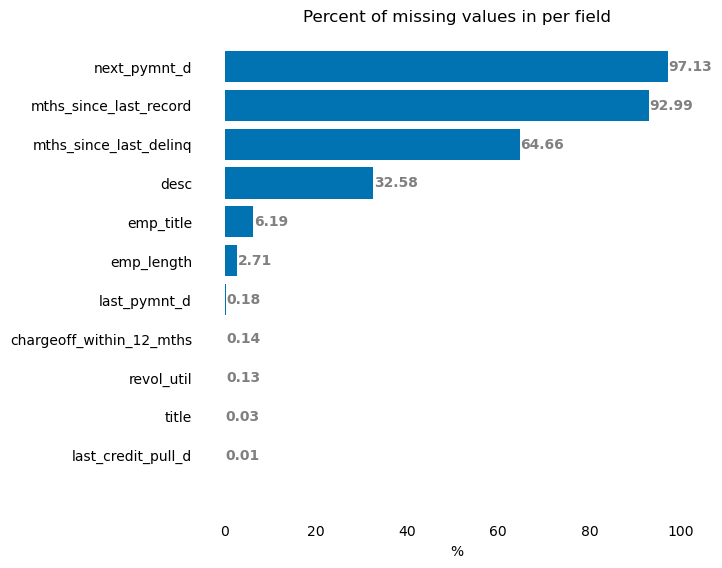

In [224]:
missing_df = loandata.isnull().sum() * 100 / len(loandata)
missing_df.to_frame(name="percent_missing")

missing_df = missing_df.reset_index()
missing_df.columns = ['field', 'percent_missing']
missing_df = missing_df.sort_values(by="percent_missing", ascending=False)

# Filter high-percentage missing

missing_df = missing_df[missing_df['percent_missing'] > 0]
# Figure Size
fig, ax = plt.subplots(figsize =(6, 6))
 
# Horizontal Bar Plot
ax.barh(missing_df["field"], missing_df["percent_missing"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Set title
ax.set_title('Percent of missing values in per field')
ax.set_xlabel('%')


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

### Drop Fields which has high number of missing values
##### We are dropping fields which have more than 90% missing values
- mths_since_last_record
- next_pymnt_d


In [225]:
loandata.drop(['mths_since_last_record', 'next_pymnt_d'], axis = 1, inplace = True)
loandata.shape

(39717, 43)

### Drop Fields which has most of the numbers at 0 and remaning are outliers
Dropping the following fields
- delinq_2yrs
- pub_rec
- out_prncp
- out_prncp_inv

In [226]:
dropping_fields = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv']
loandata = loandata.drop(columns=dropping_fields)
loandata.shape

(39717, 39)

### Drop Fields which are not of any use like zip_code, last_pymnt_amnt, etc


In [227]:
dropping_fields=['emp_title', 'desc', 'title', 'zip_code', 'mths_since_last_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt']
loandata.drop(["last_credit_pull_d","revol_bal", "total_rec_prncp","funded_amnt", "chargeoff_within_12_mths"], axis = 1, inplace = True)
loandata = loandata.drop(columns=dropping_fields)
loandata.shape

(39717, 21)

In [228]:
loandata.columns

Index(['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'revol_util', 'total_acc'],
      dtype='object')

### We are intrested with fully paid or charged off loans.
We are not intrested with the current ongoing loans. 

In [229]:
loandata = loandata[loandata.loan_status != "Current"]
loandata.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [230]:
loandata['loan_status'].value_counts()


Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

In [231]:
# Using rstrip to remove the percentage sign
loandata['int_rate'] = loandata['int_rate'].str.rstrip('%')
loandata['revol_util'] = loandata['revol_util'].str.rstrip('%')

In [232]:
loandata[['int_rate', 'revol_util']] =loandata[['int_rate', 'revol_util']].apply(pd.to_numeric)

## Outlier Treatment

<Axes: >

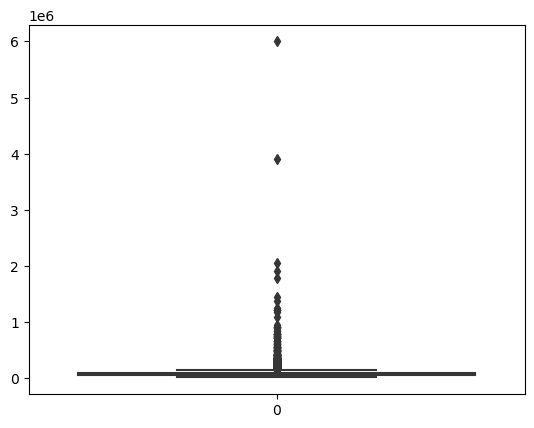

In [233]:
sns.boxplot(loandata['annual_inc'])

In [234]:
quantile_info = loandata.annual_inc.quantile([0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
quantile_info

0.50     58868.0
0.75     82000.0
0.90    115000.0
0.95    140004.0
0.97    165000.0
0.98    187000.0
0.99    234144.0
Name: annual_inc, dtype: float64

<Axes: >

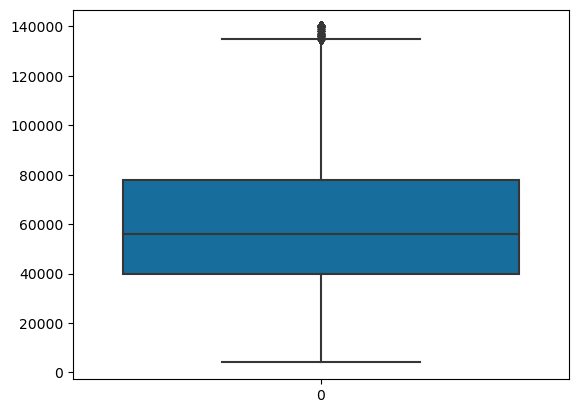

In [235]:
per_95_annual_inc = loandata['annual_inc'].quantile(0.95)
loandata = loandata[loandata.annual_inc <= per_95_annual_inc]
sns.boxplot(loandata.annual_inc)

### UNIVARIATE ANALYSIS

## Visualizing Categorical Data 


<Axes: xlabel='loan_status', ylabel='count'>

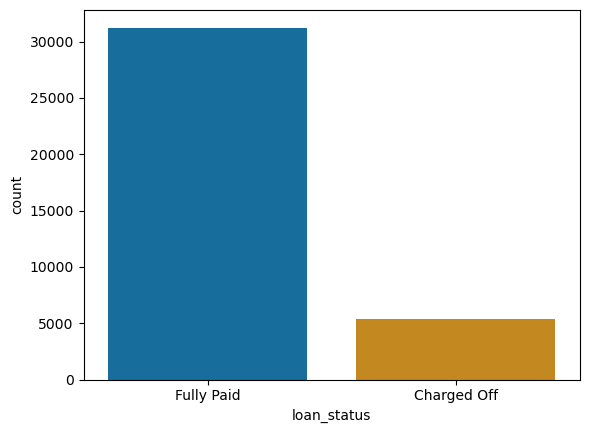

In [236]:
sns.countplot(x = 'loan_status', data = loandata)

In [237]:
loandata.sub_grade = pd.to_numeric(loandata.sub_grade.apply(lambda x : x[-1]))
loandata.sub_grade.head()

0    2
1    4
2    5
3    1
5    4
Name: sub_grade, dtype: int64

## A. UNORDERED CATEGORICAL DATA


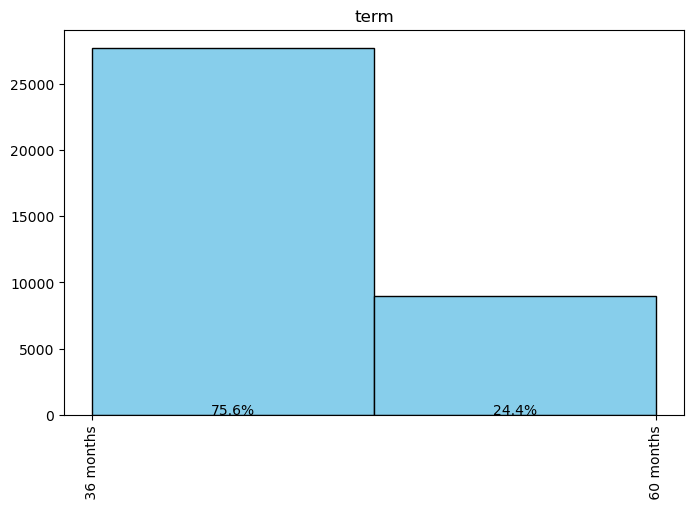

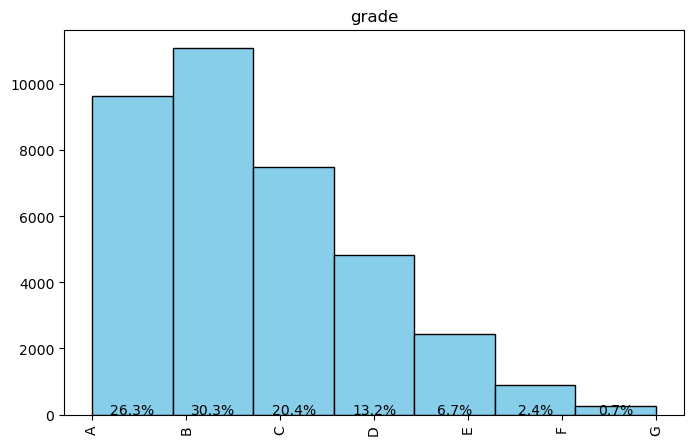

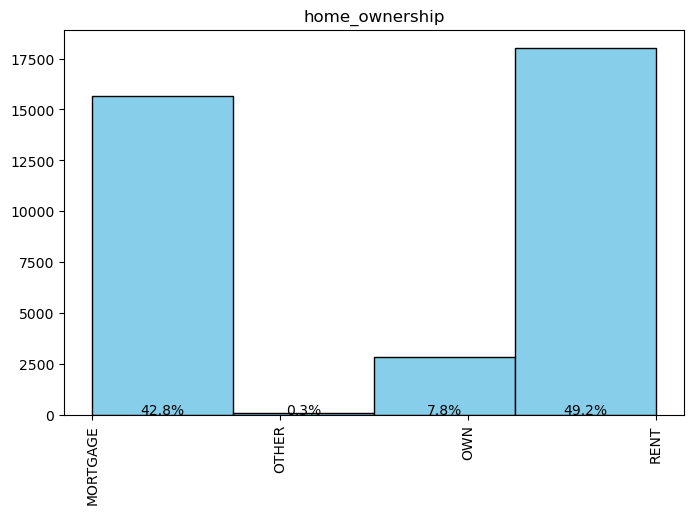

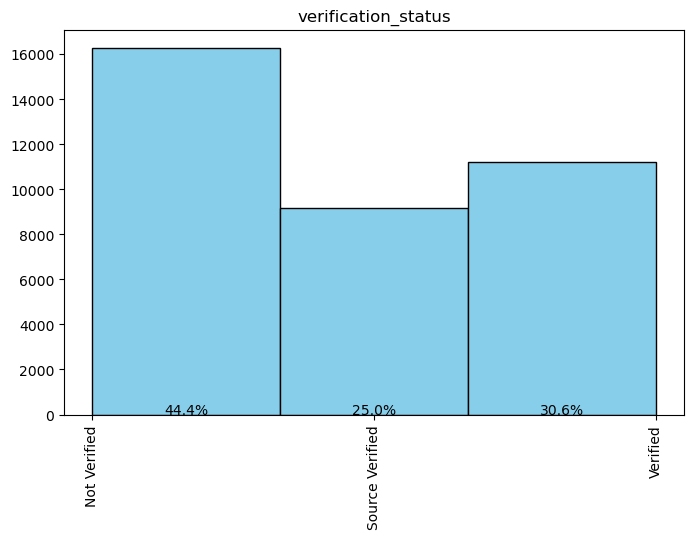

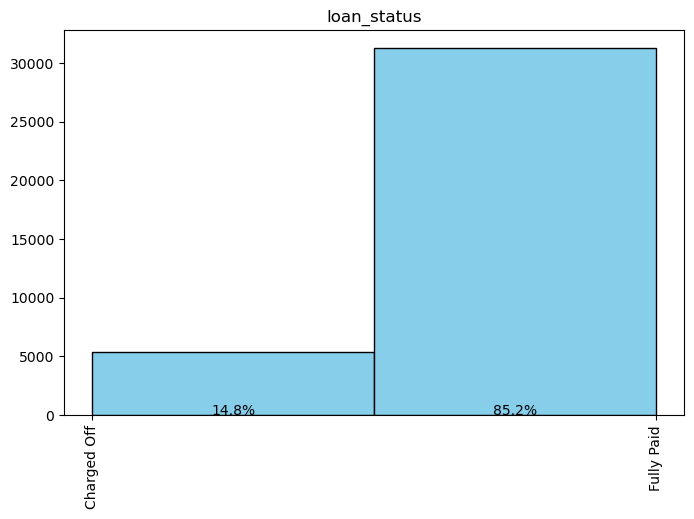

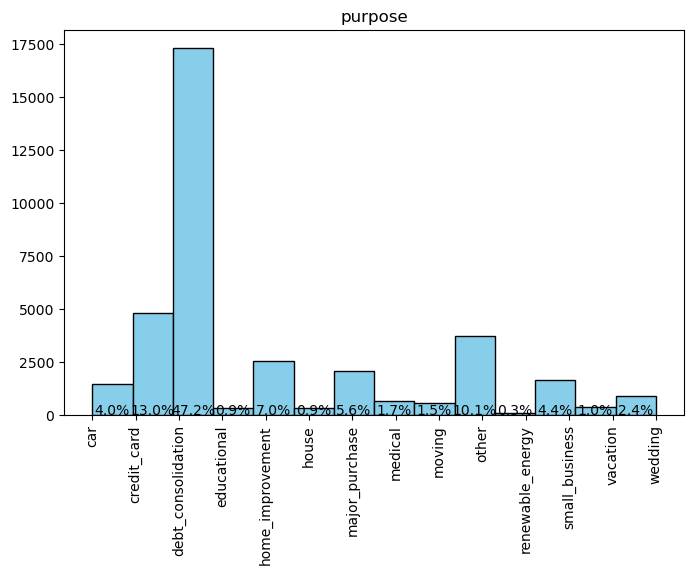

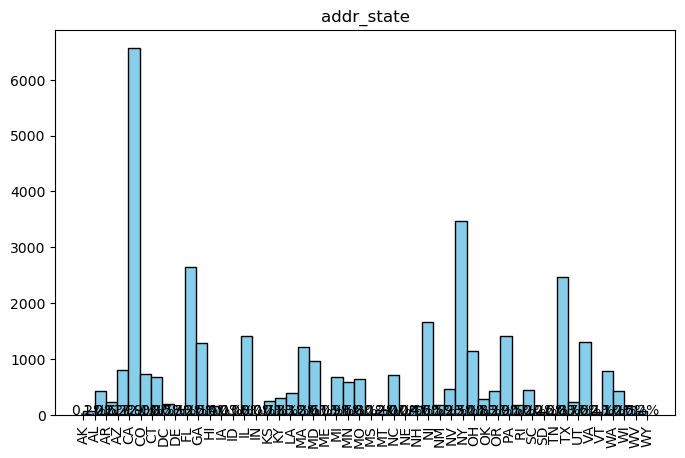

In [252]:
unordered_categorical = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

for field in unordered_categorical:
    item_count = loandata[field].nunique()
    plt.figure(figsize=(8,5),facecolor='white',edgecolor='blue')

    dataset = loandata[field].sort_values()
    n, bins, patches = plt.hist(dataset, bins=item_count, color='skyblue', edgecolor='black')

    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(loandata[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')

    plt.show()

<Axes: xlabel='grade', ylabel='count'>

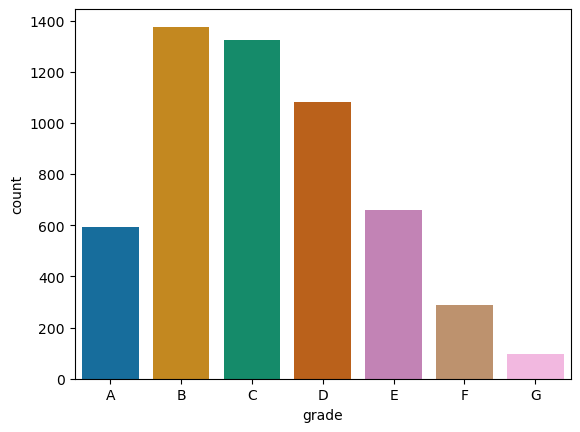

In [253]:
sns.countplot(x = 'grade', data = loandata[loandata.loan_status == 'Charged Off'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

####  Analyzing home_ownership

In [254]:
#checking unique values for home_ownership
loandata['home_ownership'].unique()


array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [255]:
#replacing 'NONE' with 'OTHERS'
loandata['home_ownership'].replace(to_replace = ['NONE'],value='OTHER',inplace = True)
#checking unique values for home_ownership again
loandata['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

<Axes: xlabel='home_ownership', ylabel='count'>

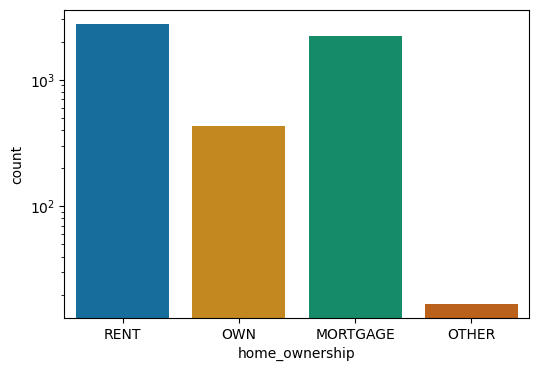

In [256]:
fig, ax = plt.subplots(figsize = (6,4))
ax.set(yscale = 'log')
sns.countplot(x='home_ownership', data=loandata[loandata['loan_status']=='Charged Off'])

<Axes: xlabel='count', ylabel='purpose'>

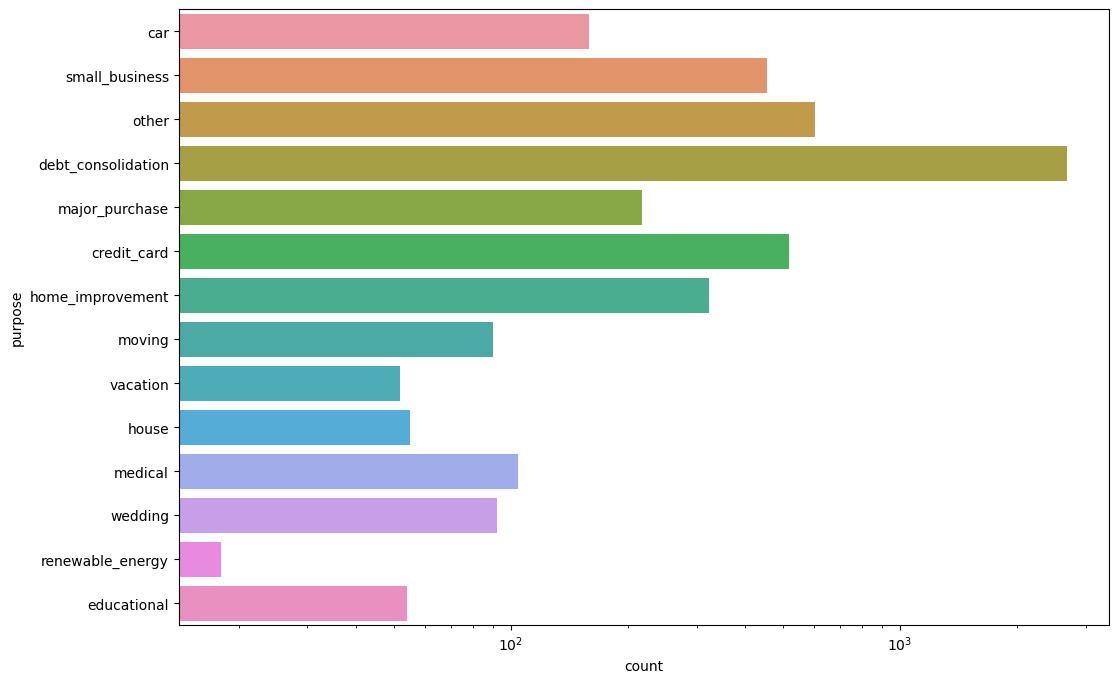

In [257]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set(xscale = 'log')
sns.countplot(y ='purpose', data=loandata[loandata.loan_status == 'Charged Off'])

### Creating bins for some numerical variable to make them categorical

In [258]:
#creating bins for int_rate,open_acc,revol_util,total_acc

loandata['int_rate_groups'] = pd.cut(loandata['int_rate'], bins=5,precision =0,labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])
loandata['open_acc_groups'] = pd.cut(loandata['open_acc'],bins = 5,precision =0,labels=['2-10','10-19','19-27','27-36','36-44'])
loandata['revol_util_groups'] = pd.cut(loandata['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])
loandata['total_acc_groups'] = pd.cut(loandata['total_acc'], bins=5,precision =0,labels=['2-20','20-37','37-55','55-74','74-90'])
loandata['annual_inc_groups'] = pd.cut(loandata['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])
# Viewing new bins created
loandata.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,int_rate_groups,open_acc_groups,revol_util_groups,total_acc_groups,annual_inc_groups
0,5000,4975.0,36 months,10.65,162.87,B,2,10+ years,RENT,24000.0,...,Jan-85,1,3,83.7,9,9%-13%,2-10,80-100,2-20,3k-31k
1,2500,2500.0,60 months,15.27,59.83,C,4,< 1 year,RENT,30000.0,...,Apr-99,5,3,9.4,4,13%-17%,2-10,0-20,2-20,3k-31k
2,2400,2400.0,36 months,15.96,84.33,C,5,10+ years,RENT,12252.0,...,Nov-01,2,2,98.5,10,13%-17%,2-10,80-100,2-20,3k-31k
3,10000,10000.0,36 months,13.49,339.31,C,1,10+ years,RENT,49200.0,...,Feb-96,1,10,21.0,37,13%-17%,2-10,20-40,20-37,31k-58k
5,5000,5000.0,36 months,7.90,156.46,A,4,3 years,RENT,36000.0,...,Nov-04,3,9,28.3,12,5%-9%,2-10,20-40,2-20,31k-58k


##  Ordered Categorical Variables

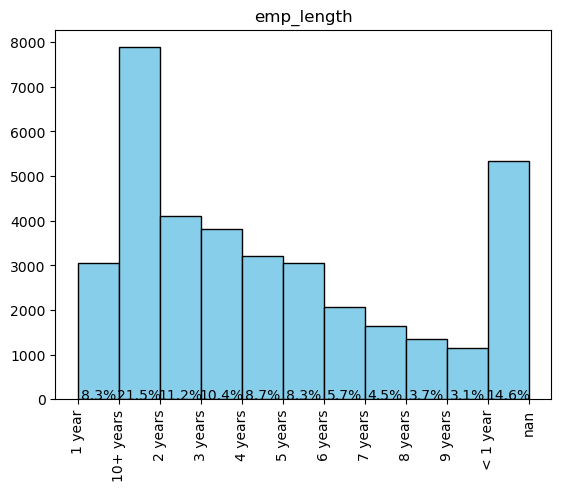

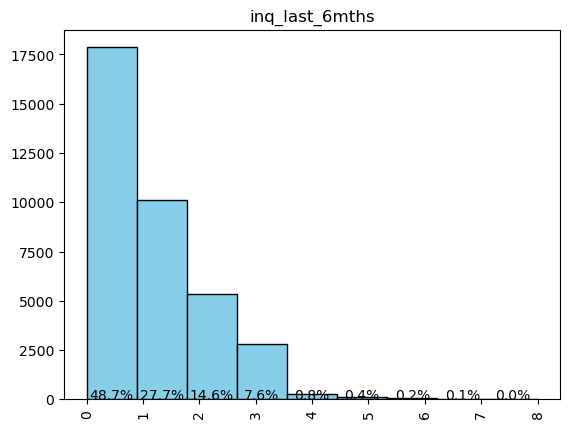

In [259]:
ordered_categorical = ['emp_length', 'inq_last_6mths']


for field in ordered_categorical:
    item_count = loandata[field].nunique()
    dataset = loandata[field].sort_values().astype(str).dropna()
    n, bins, patches = plt.hist(dataset, bins=item_count,color='skyblue', edgecolor='black')
    
    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(loandata[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')
    
    plt.show()

## C. Quantitative Variable Analysis

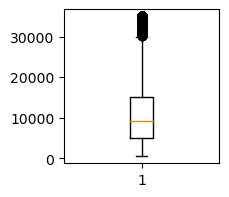

count    36654.000000
mean     10682.249550
std       7048.414166
min        500.000000
25%       5000.000000
50%       9250.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
**************************************************


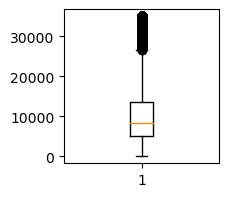

count    36654.000000
mean      9894.181349
std       6730.756232
min          0.000000
25%       4975.000000
50%       8375.000000
75%      13623.731415
max      35000.000000
Name: funded_amnt_inv, dtype: float64
**************************************************


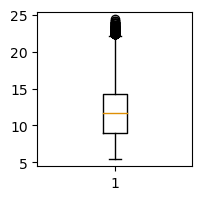

count    36654.000000
mean        11.888080
std          3.667257
min          5.420000
25%          8.940000
50%         11.710000
75%         14.270000
max         24.400000
Name: int_rate, dtype: float64
**************************************************


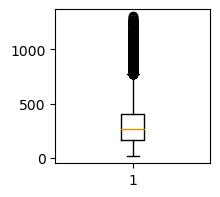

count    36654.000000
mean       311.888682
std        199.230096
min         15.690000
25%        163.080000
50%        270.420000
75%        408.480000
max       1305.190000
Name: installment, dtype: float64
**************************************************


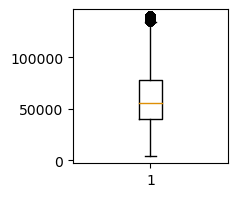

count     36654.000000
mean      60855.751621
std       27750.284125
min        4000.000000
25%       40000.000000
50%       56000.000000
75%       77970.500000
max      140004.000000
Name: annual_inc, dtype: float64
**************************************************


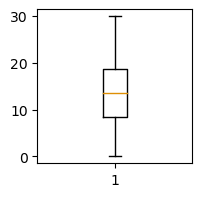

count    36654.000000
mean        13.446725
std          6.661899
min          0.000000
25%          8.350000
50%         13.580000
75%         18.710000
max         29.990000
Name: dti, dtype: float64
**************************************************


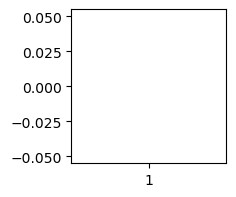

count    36606.000000
mean        48.659741
std         28.282836
min          0.000000
25%         25.300000
50%         49.000000
75%         72.100000
max         99.900000
Name: revol_util, dtype: float64
**************************************************


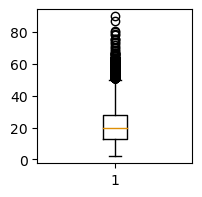

count    36654.000000
mean        21.641349
std         11.232836
min          2.000000
25%         13.000000
50%         20.000000
75%         28.000000
max         90.000000
Name: total_acc, dtype: float64
**************************************************


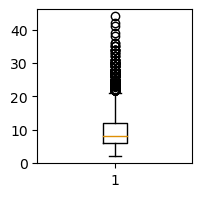

count    36654.000000
mean         9.167294
std          4.353165
min          2.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64
**************************************************


In [264]:
quantitative_fields = ['loan_amnt',  'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',  'revol_util', 'total_acc', 'open_acc']

for field in quantitative_fields:
    plt.figure(figsize=(2,2))
    plt.boxplot(loandata[field])
    plt.show()
    print(loandata[field].describe())
    print("*" * 50)


# 4. Segmented Univariate Analysis
___

field =  loan_amnt     Category =  term 



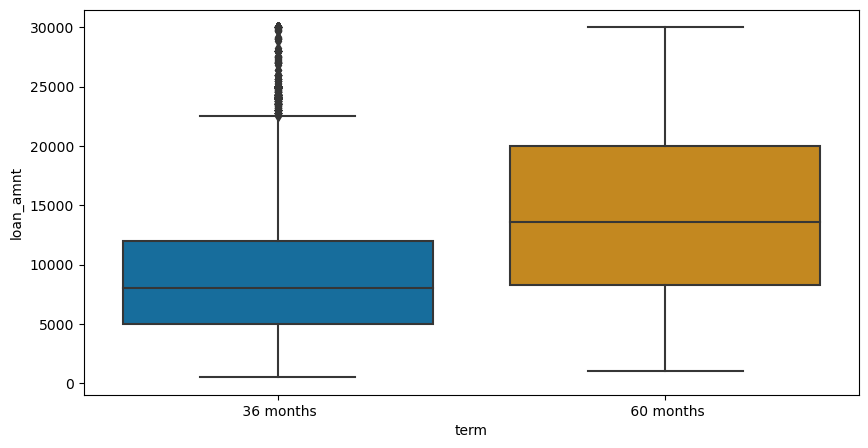

               loan_amnt                                              
                    mean   min    max <lambda_0> <lambda_1> <lambda_2>
term                                                                  
 36 months   9283.025504   500  35000     5000.0     8000.0    12000.0
 60 months  15024.339528  1000  35000     8500.0    14000.0    20000.0
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  grade 



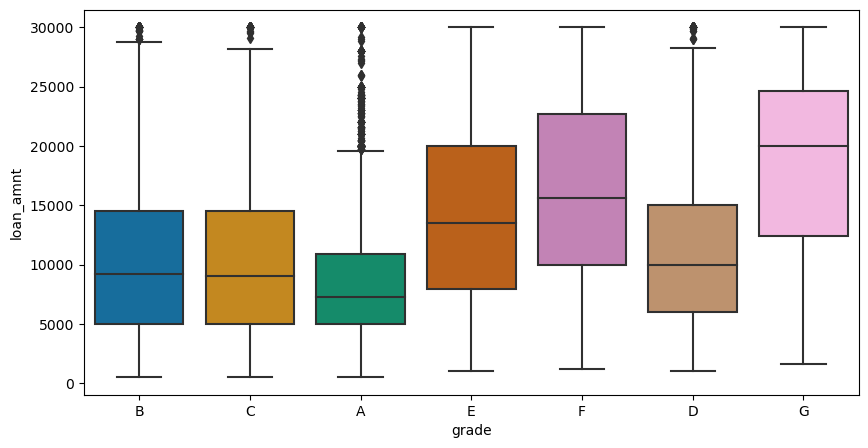

          loan_amnt                                              
               mean   min    max <lambda_0> <lambda_1> <lambda_2>
grade                                                            
A       8435.048207   500  35000     5000.0     7350.0   11000.00
B      10588.057583   500  35000     5000.0     9500.0   15000.00
C      10485.142361   500  35000     5000.0     9000.0   15000.00
D      11778.883144  1000  35000     6000.0    10000.0   16000.00
E      15049.264706  1000  35000     8000.0    14400.0   20000.00
F      17347.968397  1200  35000    10000.0    17412.5   24593.75
G      19486.111111  1600  35000    12900.0    20000.0   25000.00
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  home_ownership 



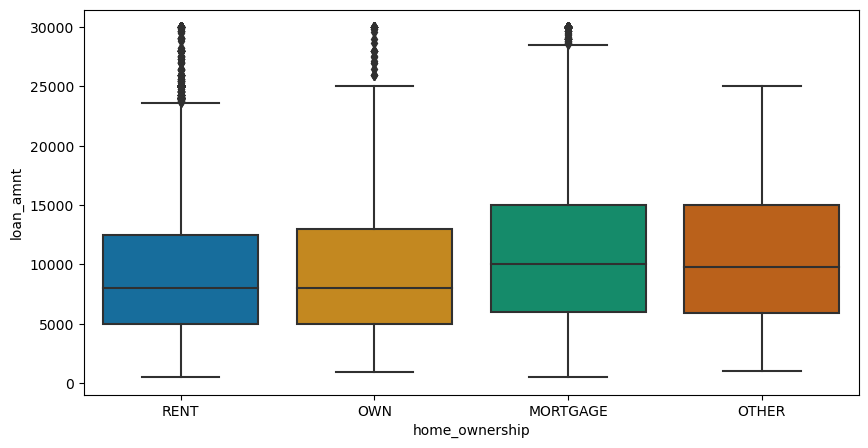

                   loan_amnt                                              
                        mean   min    max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                            
MORTGAGE        11961.716108   500  35000     6000.0    10000.0   16000.00
OTHER           10346.614583  1000  25000     5937.5     9800.0   15000.00
OWN              9818.294180   900  35000     5000.0     8000.0   13481.25
RENT             9708.403583   500  35000     5000.0     8000.0   12800.00
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  verification_status 



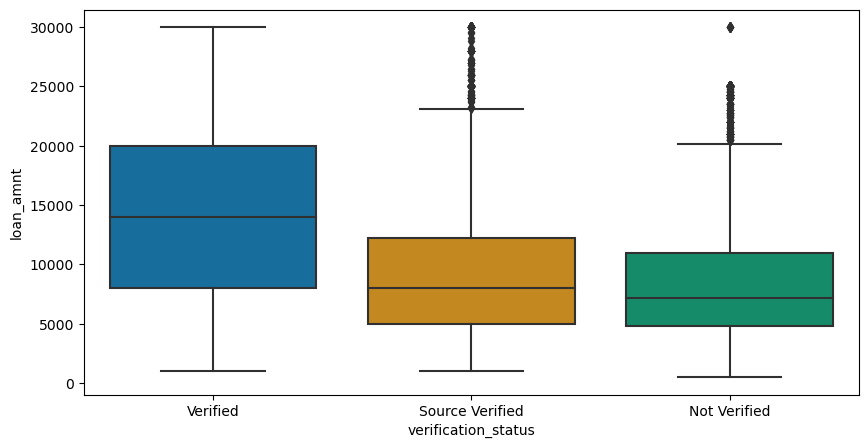

                        loan_amnt                                     \
                             mean   min    max <lambda_0> <lambda_1>   
verification_status                                                    
Not Verified          8268.290848   500  35000     4800.0     7200.0   
Source Verified       9539.055161  1000  35000     5000.0     8050.0   
Verified             15118.045280  1000  35000     8000.0    14700.0   

                                
                    <lambda_2>  
verification_status             
Not Verified           11000.0  
Source Verified        12500.0  
Verified               20000.0  
--------------------------------------------------------------------------------
field =  loan_amnt     Category =  purpose 



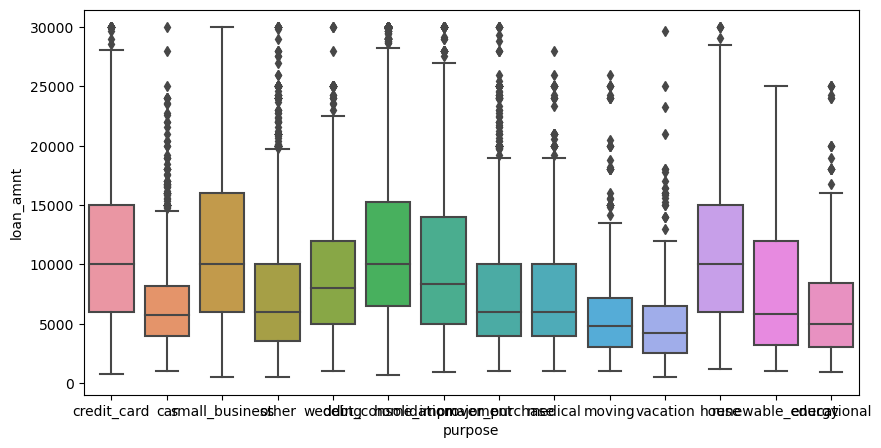

                       loan_amnt                                              
                            mean   min    max <lambda_0> <lambda_1> <lambda_2>
purpose                                                                       
car                  6635.773481  1000  30000     4000.0     5725.0     8200.0
credit_card         11244.511813   725  35000     6000.0    10000.0    15000.0
debt_consolidation  12188.484542   700  35000     6800.0    10625.0    16000.0
educational          6604.166667   900  25000     3000.0     5000.0     8425.0
home_improvement    10454.049296   900  35000     5000.0     8500.0    14400.0
house               11878.698225  1200  35000     6000.0    10000.0    15000.0
major_purchase       7755.229717  1000  35000     4000.0     6000.0    10000.0
medical              7803.198128  1000  35000     4000.0     6000.0    10000.0
moving               6015.500000  1000  35000     3000.0     4800.0     7237.5
other                7641.328737   500  35000     35

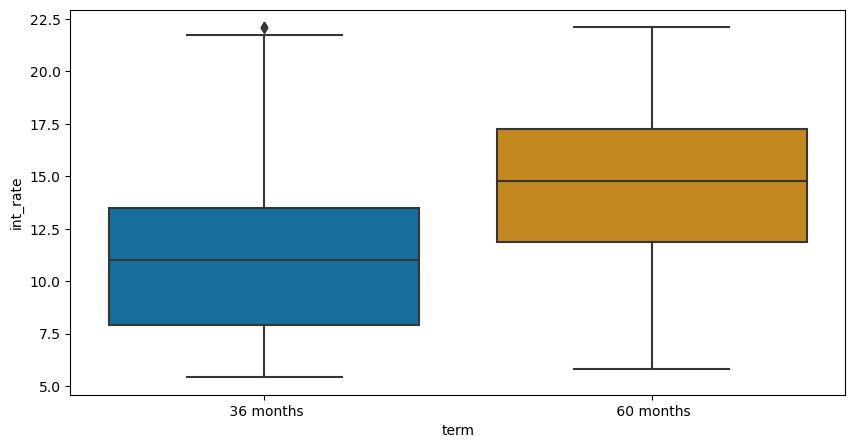

             int_rate                                              
                 mean   min    max <lambda_0> <lambda_1> <lambda_2>
term                                                               
 36 months  10.981333  5.42  23.22       7.90      10.99      13.47
 60 months  14.701908  5.79  24.40      11.86      14.79      17.27
--------------------------------------------------------------------------------
field =  int_rate     Category =  grade 



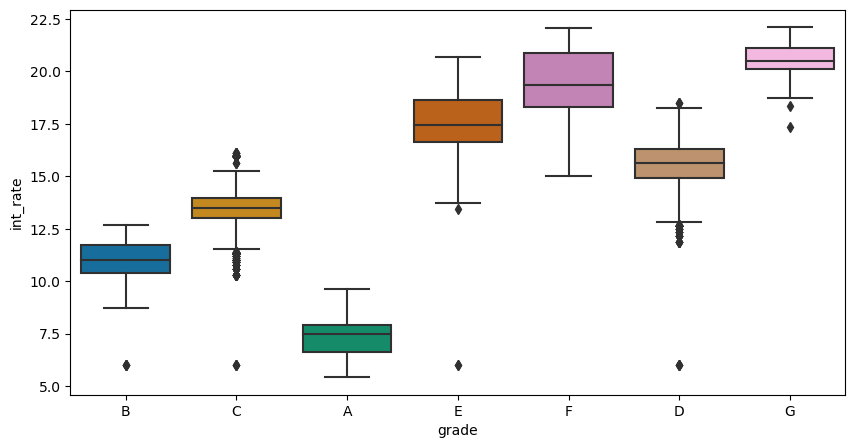

        int_rate                                               
            mean    min    max <lambda_0> <lambda_1> <lambda_2>
grade                                                          
A       7.327457   5.42   9.63       6.62       7.49       7.90
B      11.005021   6.00  12.69      10.37      10.99      11.71
C      13.531575   6.00  16.11      12.99      13.49      13.99
D      15.657957   6.00  18.49      14.91      15.62      16.32
E      17.600404   6.00  20.69      16.63      17.43      18.64
F      19.615384  15.01  22.94      18.43      19.36      20.89
G      21.231264  17.34  24.40      20.16      20.85      22.11
--------------------------------------------------------------------------------
field =  int_rate     Category =  home_ownership 



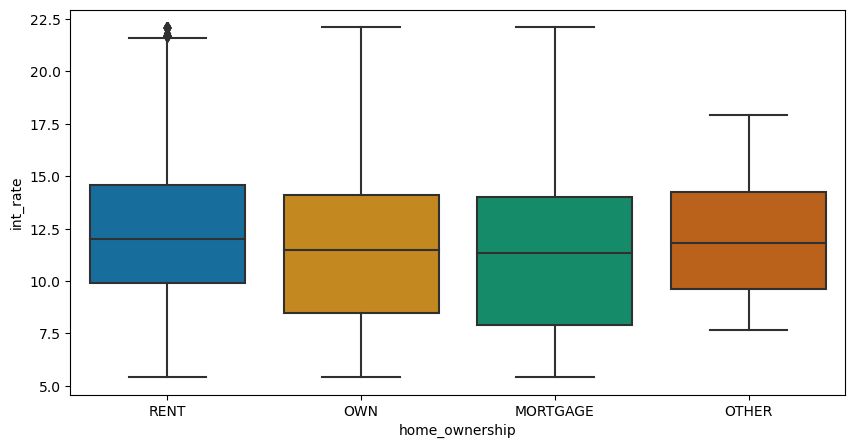

                 int_rate                                              
                     mean   min    max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                         
MORTGAGE        11.575828  5.42  24.11       7.90      11.36     14.090
OTHER           11.979792  7.68  17.90       9.63      11.83     14.260
OWN             11.686122  5.42  23.59       8.49      11.49     14.125
RENT            12.190988  5.42  24.40       9.91      11.99     14.610
--------------------------------------------------------------------------------
field =  int_rate     Category =  verification_status 



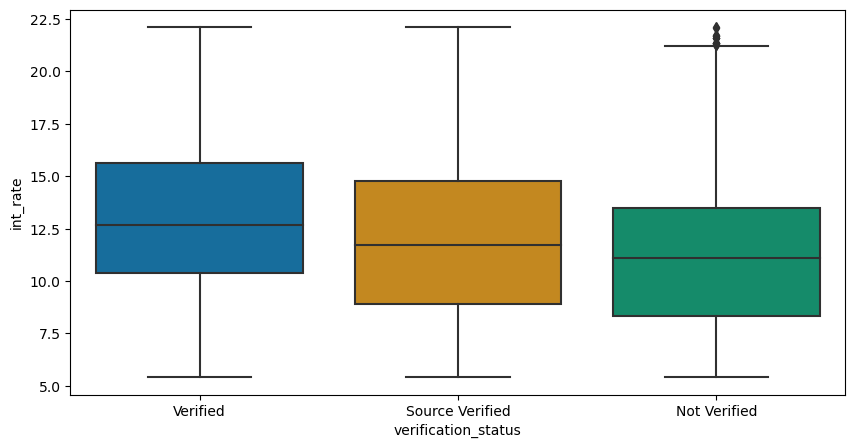

                      int_rate                                              
                          mean   min    max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                         
Not Verified         11.157193  5.42  24.40       8.32      11.12      13.49
Source Verified      11.971732  5.42  23.91       8.90      11.83      14.79
Verified             12.880414  5.42  24.11      10.36      12.69      15.65
--------------------------------------------------------------------------------
field =  int_rate     Category =  purpose 



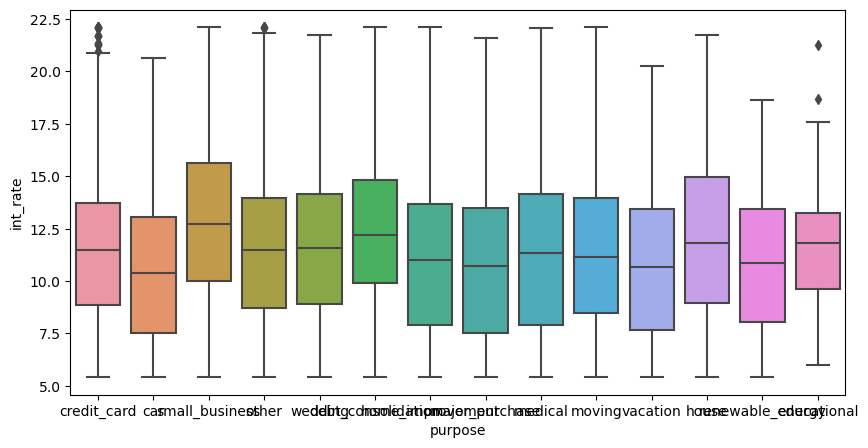

                     int_rate                                              
                         mean   min    max <lambda_0> <lambda_1> <lambda_2>
purpose                                                                    
car                 10.482417  5.42  22.85      7.510     10.370    13.0600
credit_card         11.571033  5.42  24.11      8.890     11.480    13.7900
debt_consolidation  12.344978  5.42  24.11      9.910     12.210    14.8400
educational         11.627115  6.00  21.27      9.630     11.805    13.2225
home_improvement    11.183623  5.42  22.11      7.880     10.990    13.6825
house               12.074527  5.42  23.13      8.940     11.830    15.0275
major_purchase      10.784374  5.42  23.59      7.510     10.740    13.4900
medical             11.458206  5.42  22.06      7.900     11.340    14.1700
moving              11.486891  5.42  22.11      8.490     11.130    13.9800
other               11.665431  5.42  23.22      8.880     11.490    13.9800
renewable_en

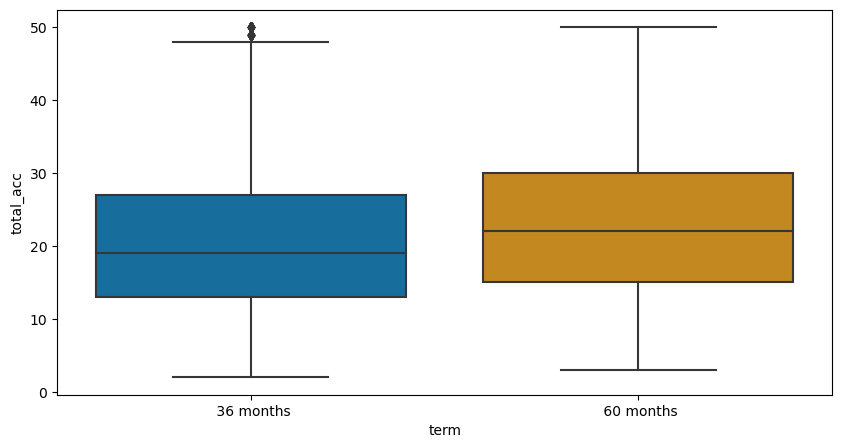

            total_acc                                         
                 mean min max <lambda_0> <lambda_1> <lambda_2>
term                                                          
 36 months  21.052018   2  90       13.0       19.0       27.0
 60 months  23.470167   3  87       15.0       22.0       31.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  grade 



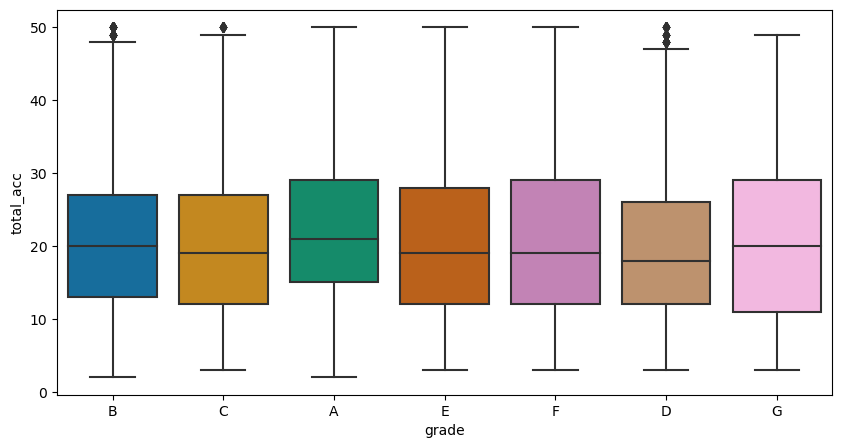

       total_acc                                         
            mean min max <lambda_0> <lambda_1> <lambda_2>
grade                                                    
A      23.213249   2  79       15.0       22.0       29.0
B      21.492836   2  90       13.0       20.0       28.0
C      20.581339   3  87       12.0       19.0       27.0
D      20.334023   3  80       12.0       18.0       27.0
E      21.424020   3  74       12.0       19.0       29.0
F      22.759594   3  81       13.0       20.0       31.0
G      22.704981   3  78       12.0       20.0       31.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  home_ownership 



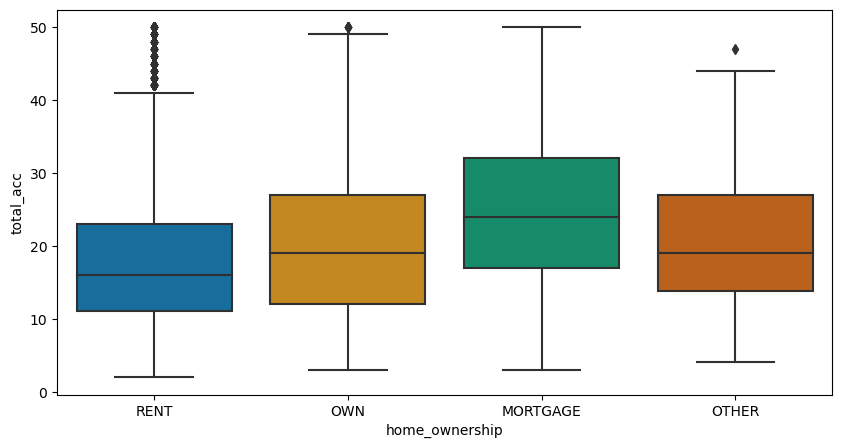

                total_acc                                         
                     mean min max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                    
MORTGAGE        25.767400   3  87      17.00       24.0       32.0
OTHER           21.041667   4  47      13.75       19.0       27.0
OWN             20.664095   3  75      12.00       19.0       27.0
RENT            18.212190   2  90      11.00       16.0       24.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  verification_status 



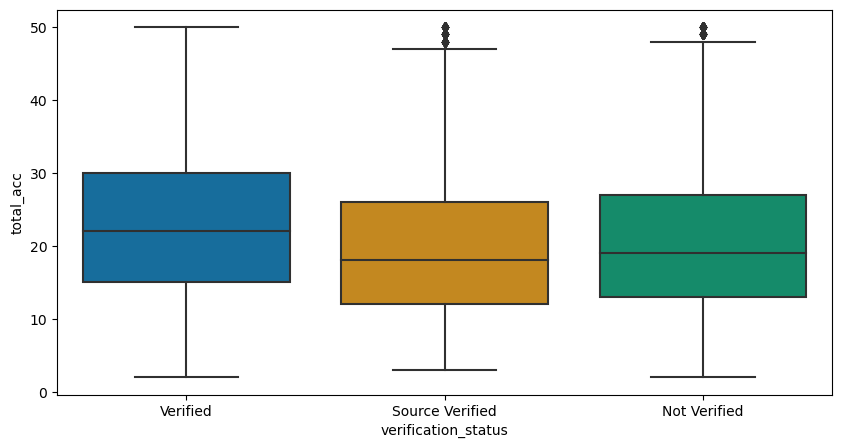

                     total_acc                                         
                          mean min max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                    
Not Verified         20.889619   2  90       13.0       19.0       27.0
Source Verified      20.342217   3  87       12.0       19.0       27.0
Verified             23.792317   2  76       15.0       22.0       31.0
--------------------------------------------------------------------------------
field =  total_acc     Category =  purpose 



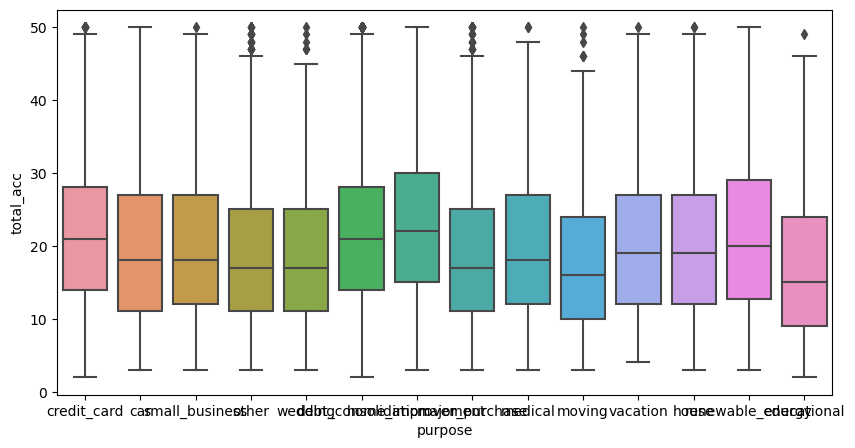

                    total_acc                                         
                         mean min max <lambda_0> <lambda_1> <lambda_2>
purpose                                                               
car                 20.444061   3  67       11.0       19.0       28.0
credit_card         22.461635   2  80       14.0       21.0       29.0
debt_consolidation  22.479977   2  90       14.0       21.0       29.0
educational         18.205128   2  63        9.0       15.0       25.0
home_improvement    23.559468   3  72       15.0       22.0       30.0
house               20.760355   3  62       12.0       19.0       27.0
major_purchase      19.369501   3  81       11.0       17.0       25.0
medical             20.907956   3  63       12.0       18.0       27.0
moving              18.210909   3  63       10.0       16.0       25.0
other               19.416599   3  76       11.0       18.0       26.0
renewable_energy    22.431579   3  63       13.0       21.0       29.0
small_

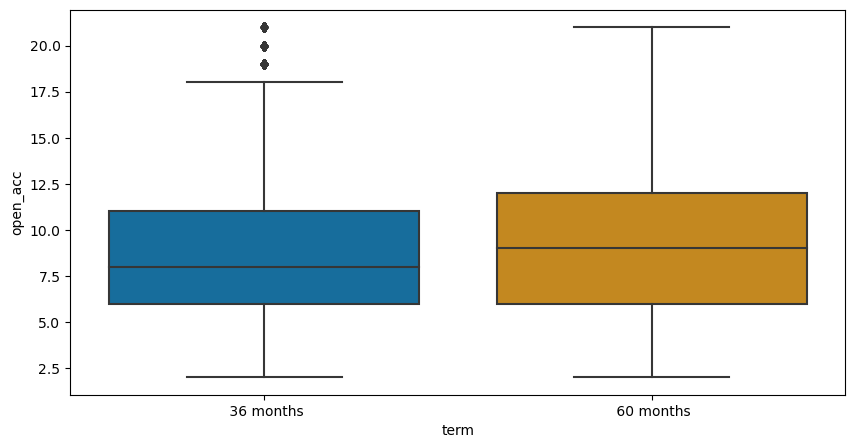

            open_acc                                         
                mean min max <lambda_0> <lambda_1> <lambda_2>
term                                                         
 36 months  9.059846   2  44        6.0        8.0       11.0
 60 months  9.500728   2  36        6.0        9.0       12.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  grade 



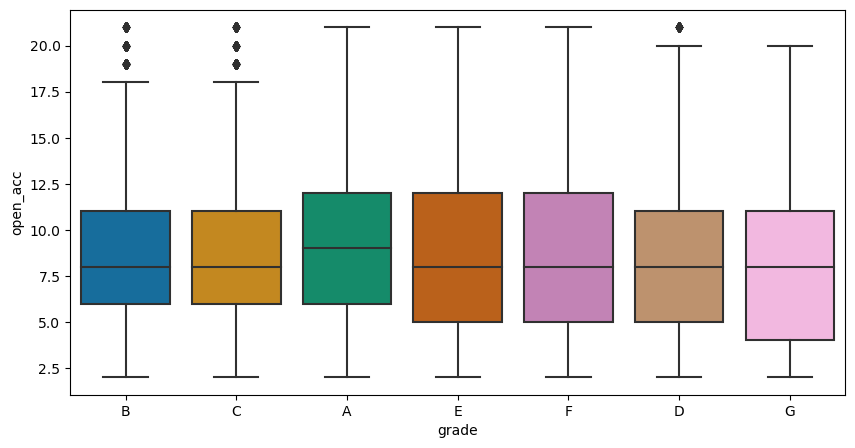

       open_acc                                         
           mean min max <lambda_0> <lambda_1> <lambda_2>
grade                                                   
A      9.378499   2  42        6.0        9.0       12.0
B      9.076597   2  32        6.0        8.0       11.0
C      9.020318   2  35        6.0        8.0       12.0
D      8.971665   2  30        6.0        8.0       11.0
E      9.228350   2  36        5.0        8.0       12.0
F      9.930023   2  39        5.0        9.0       13.0
G      9.892720   2  44        5.0        8.0       12.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  home_ownership 



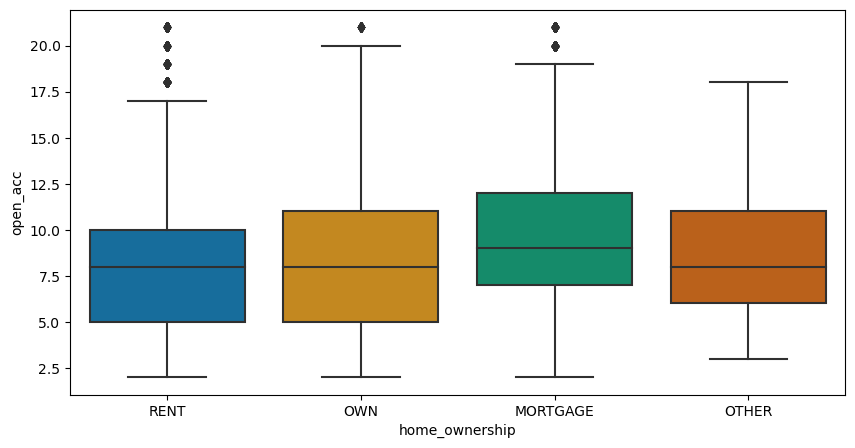

                 open_acc                                         
                     mean min max <lambda_0> <lambda_1> <lambda_2>
home_ownership                                                    
MORTGAGE        10.140096   2  42        7.0        9.0       13.0
OTHER            8.614583   3  18        6.0        8.0       11.0
OWN              8.937938   2  44        5.0        8.0       11.0
RENT             8.360823   2  34        5.0        8.0       11.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  verification_status 



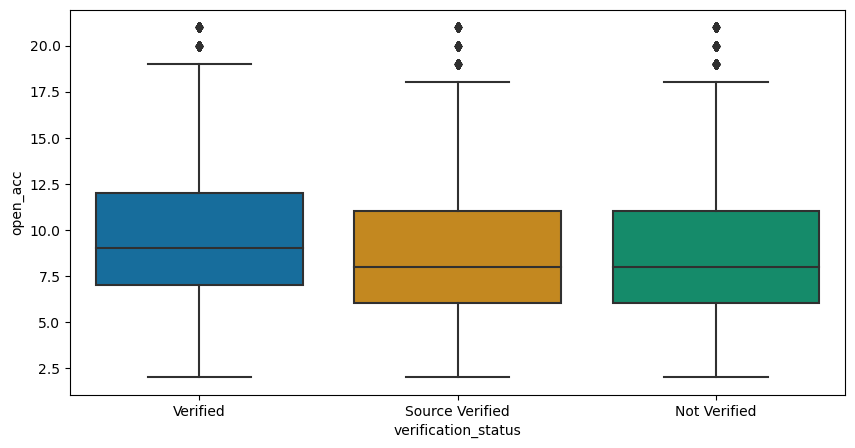

                     open_acc                                         
                         mean min max <lambda_0> <lambda_1> <lambda_2>
verification_status                                                   
Not Verified         8.959091   2  44        6.0        8.0       11.0
Source Verified      8.827744   2  36        6.0        8.0       11.0
Verified             9.746501   2  34        7.0        9.0       12.0
--------------------------------------------------------------------------------
field =  open_acc     Category =  purpose 



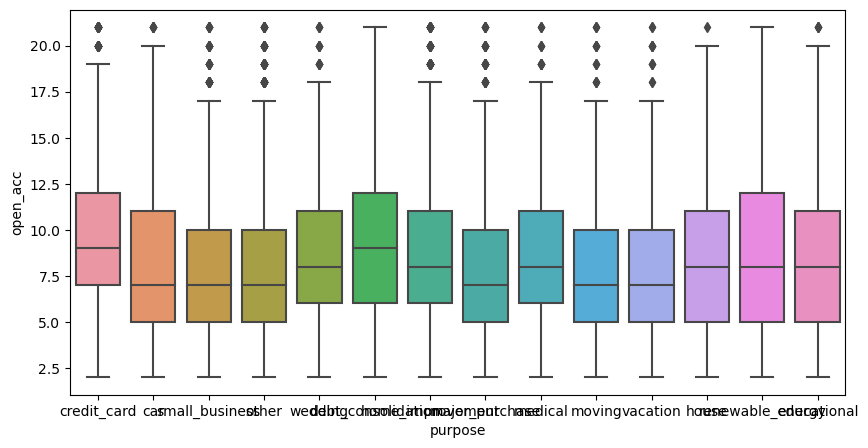

                    open_acc                                         
                        mean min max <lambda_0> <lambda_1> <lambda_2>
purpose                                                              
car                 8.531077   2  28        5.0        8.0      11.00
credit_card         9.680535   2  39        7.0        9.0      12.00
debt_consolidation  9.578099   2  44        6.0        9.0      12.00
educational         8.820513   2  35        5.0        8.0      11.25
home_improvement    9.248044   2  31        6.0        9.0      12.00
house               8.372781   2  24        5.0        8.0      11.00
major_purchase      8.124145   2  35        5.0        7.0      10.00
medical             8.762871   2  27        6.0        8.0      11.00
moving              7.987273   2  33        5.0        7.0      10.00
other               8.255204   2  42        5.0        8.0      11.00
renewable_energy    8.978947   2  25        5.0        8.0      12.00
small_business      

In [268]:
def remove_outliers(df: pd.DataFrame, field: str) -> pd.DataFrame:
    Q1 = df[field].quantile(0.25)
    Q3 = df[field].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return df[(df[field] >= lower) & (df[field] <= upper)]

categories = ['term',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose']

quantitative = ['loan_amnt',
 'int_rate',
  'total_acc',
 'open_acc']

for field in quantitative:
    for category in categories:
        print("field = ", field, "    Category = ", category,'\n')
        clean_df = remove_outliers(loandata, field)
        plt.figure(figsize=(10, 5))
        sns.boxplot(y=field, x=category, data=clean_df)
        plt.show()
        df_segment = loandata.groupby(category)
        print(df_segment.agg({field : ['mean','min','max', lambda x:x.quantile(0.25), 
                                             lambda x:x.quantile(0.5), lambda x:x.quantile(0.75)]}))
        print("-" * 80)


### Segmented Analysis on Timeseries

In [272]:
loandata['issue_d'] = loandata['issue_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
loandata['earliest_cr_line'] = loandata['earliest_cr_line'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))

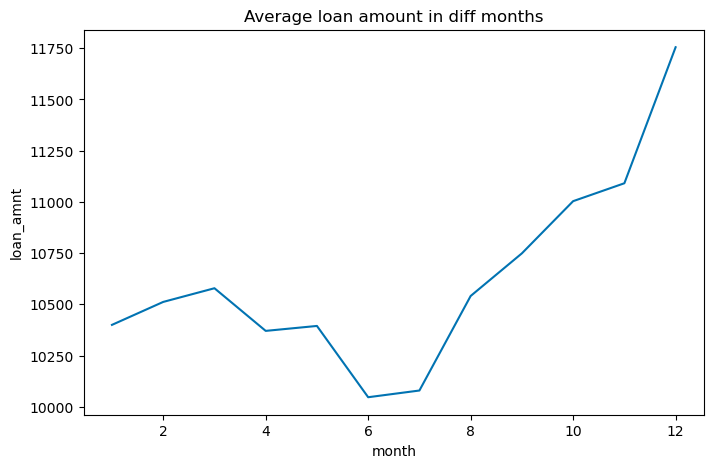

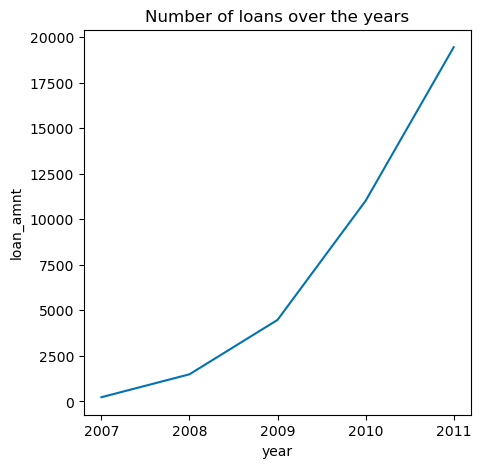

In [273]:
df_timeseries = loandata[['issue_d', 'loan_amnt']]
df_timeseries['issue_d'] = pd.to_datetime(df_timeseries['issue_d'])
df_timeseries['month'] = df_timeseries['issue_d'].dt.month
df_timeseries['year'] = df_timeseries['issue_d'].dt.year

#---------------------------------------------------------------

plt.figure(figsize=(8,5),facecolor='white',edgecolor='blue')
df_tmp = df_timeseries[["loan_amnt", 'month', 'year']]
df_tmp_agg_month = df_tmp.groupby(['month']).agg({"loan_amnt": "mean"}).reset_index()

sns.lineplot(df_tmp_agg_month[["loan_amnt", 'month']].sort_values(by='month'), 
             x = df_tmp_agg_month['month'], y = df_tmp_agg_month["loan_amnt"], markers='x')
plt.title("Average loan amount in diff months")
plt.show()

#---------------------------------------------------------------

plt.figure(figsize=(5,5),facecolor='white', edgecolor='blue')
df_tmp_agg_year = df_tmp.groupby(['year']).agg({"loan_amnt": "count"}).reset_index()

ax = sns.lineplot(df_tmp_agg_year[["loan_amnt", 'year']].sort_values(by='year'), 
             x = df_tmp_agg_year['year'], y = df_tmp_agg_year["loan_amnt"])
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title("Number of loans over the years")
plt.show()


# 5. Bivariate Analysis

## A. On Continuous/ Quantitative  Variables

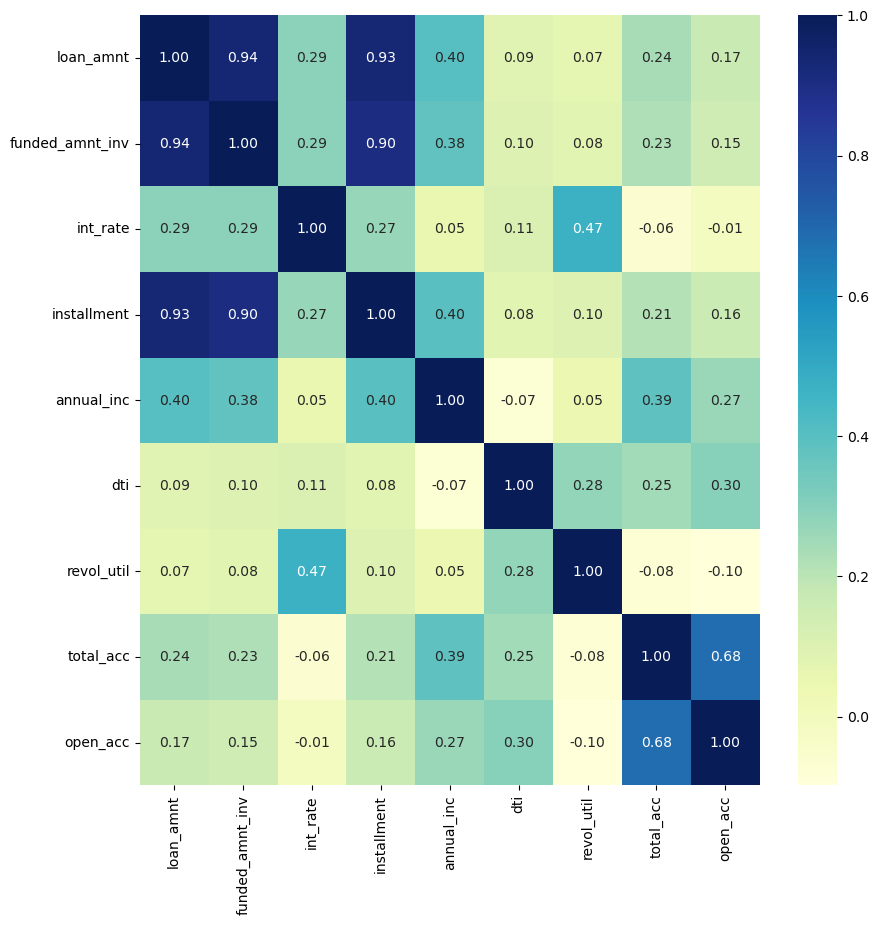

In [275]:
#sns.set()
plt.figure(figsize=(10, 10))  # Set the figure size
heatmap = sns.heatmap(loandata[['loan_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'revol_util',
 'total_acc',
 'open_acc']].corr(), fmt='0.2f', cmap="YlGnBu", annot=True)

plt.show()

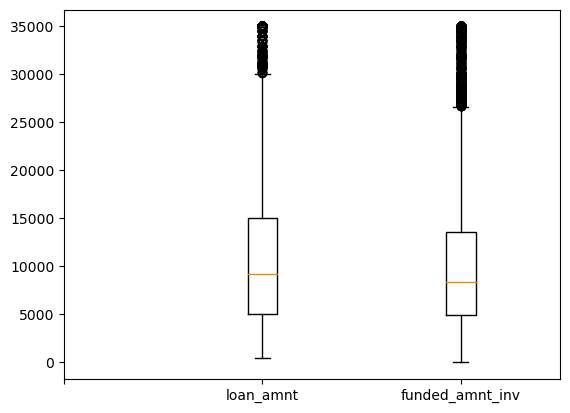

In [277]:
df_subset = loandata[['loan_amnt', 'funded_amnt_inv']]
plt.boxplot(df_subset)
x_labels = ["","loan_amnt", 'funded_amnt_inv']
plt.xticks(range(len(x_labels)), x_labels)
plt.show()

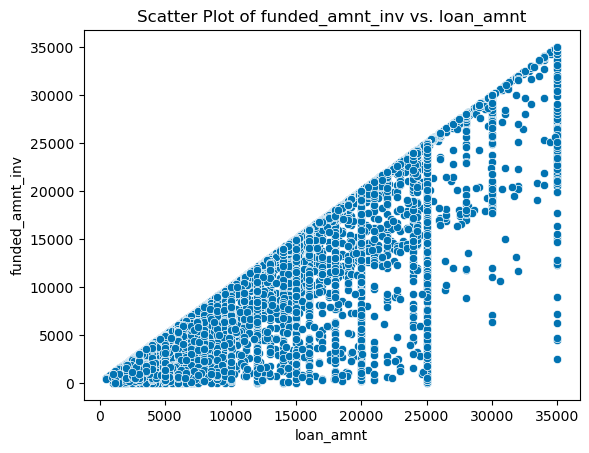

In [280]:
sns.scatterplot(data=loandata, x="loan_amnt", y="funded_amnt_inv")

# Add labels and a title
plt.xlabel("loan_amnt")
plt.ylabel("funded_amnt_inv")
plt.title("Scatter Plot of funded_amnt_inv vs. loan_amnt")

# Show the plot
plt.show()

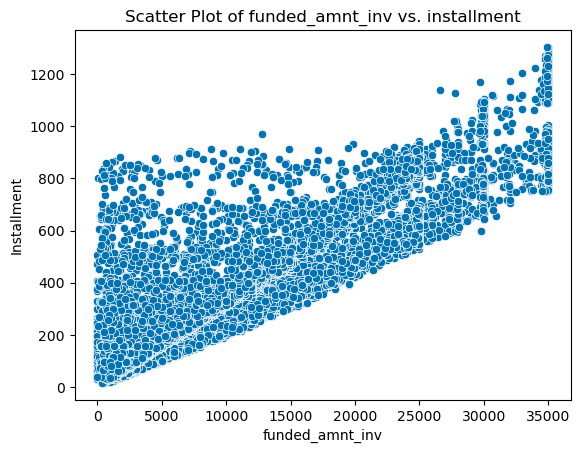

In [282]:
sns.scatterplot(data=loandata, x="funded_amnt_inv", y="installment")

# Add labels and a title
plt.xlabel("funded_amnt_inv")
plt.ylabel("Installment")
plt.title("Scatter Plot of funded_amnt_inv vs. installment")

# Show the plot
plt.show()

## B. On Categorical Variables


 % of Loans applications distributed in term and grade 



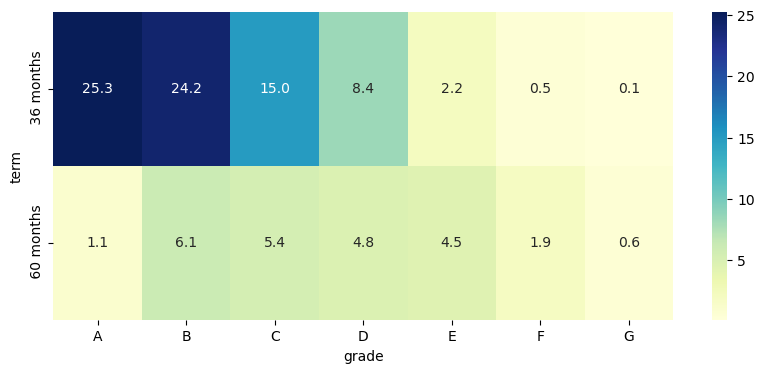


======= Impact of TERM and GRADE together on LOAN STATUS ========



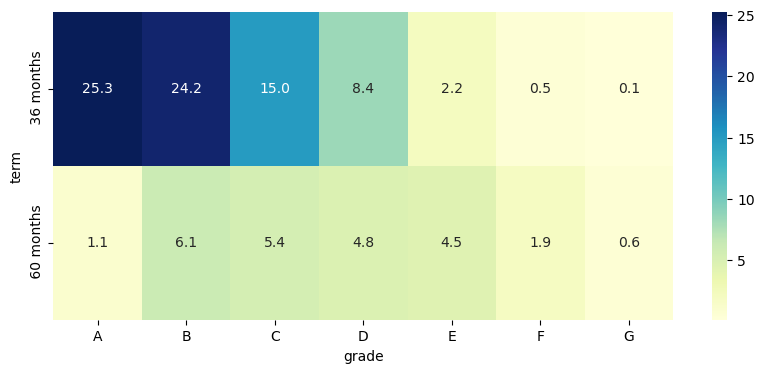

********************************************************************************

 % of Loans applications distributed in term and emp_length 



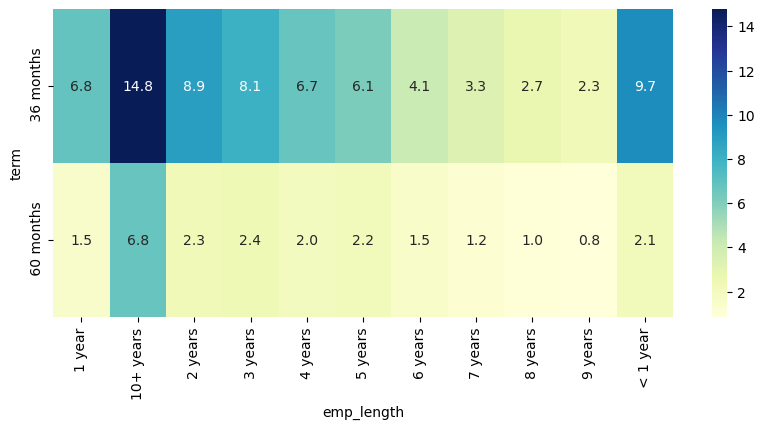


======= Impact of TERM and EMP_LENGTH together on LOAN STATUS ========



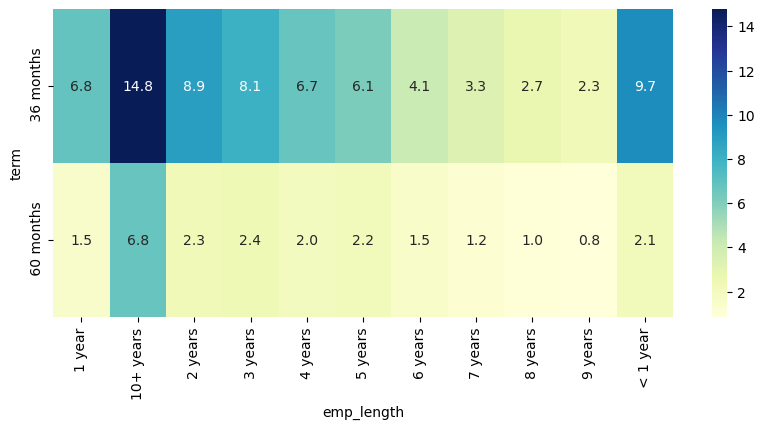

********************************************************************************

 % of Loans applications distributed in term and home_ownership 



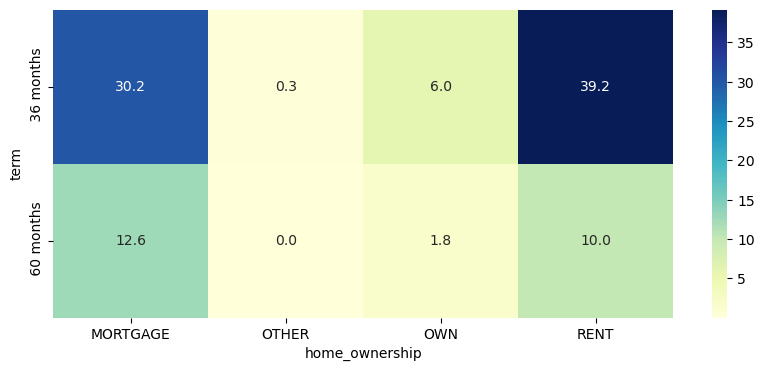


======= Impact of TERM and HOME_OWNERSHIP together on LOAN STATUS ========



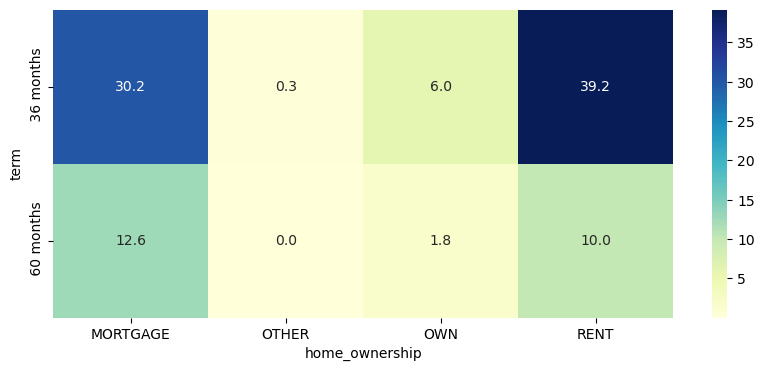

********************************************************************************

 % of Loans applications distributed in term and verification_status 



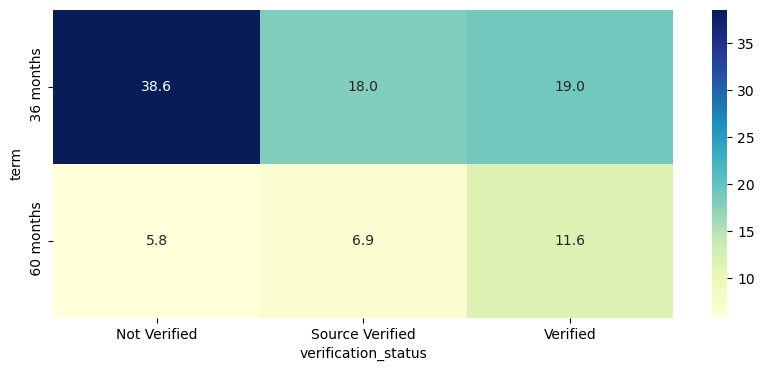


======= Impact of TERM and VERIFICATION_STATUS together on LOAN STATUS ========



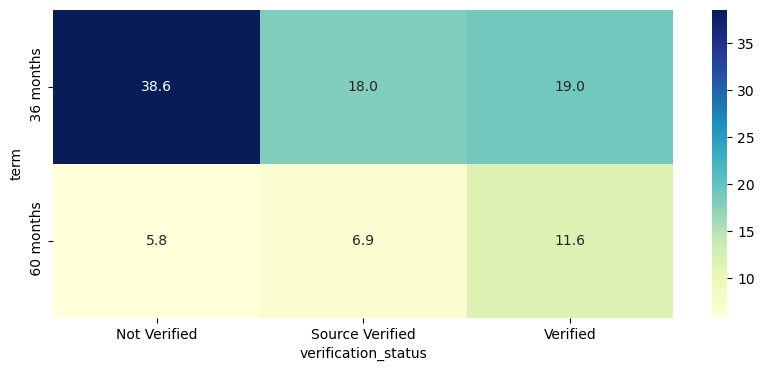

********************************************************************************

 % of Loans applications distributed in term and purpose 



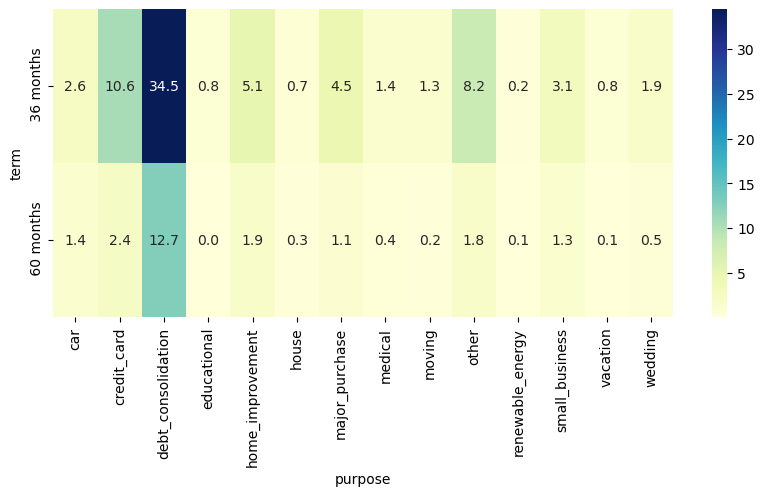


======= Impact of TERM and PURPOSE together on LOAN STATUS ========



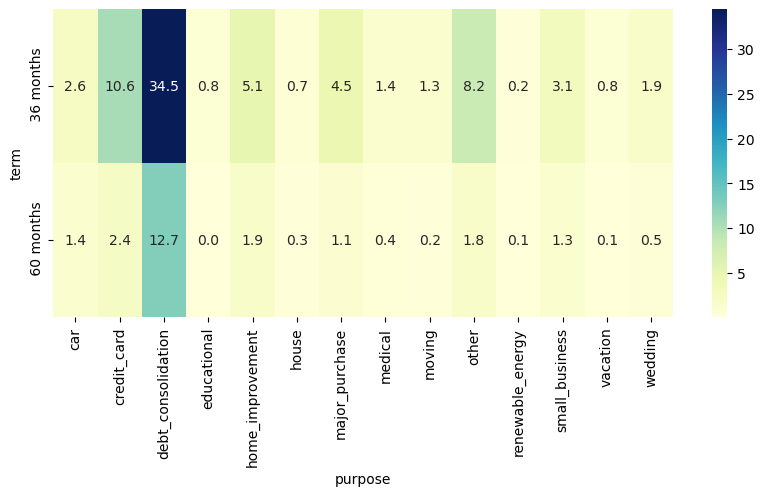

********************************************************************************

 % of Loans applications distributed in grade and emp_length 



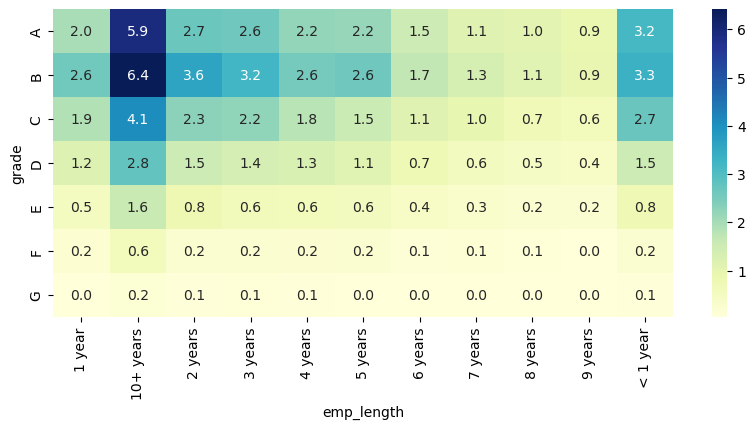


======= Impact of GRADE and EMP_LENGTH together on LOAN STATUS ========



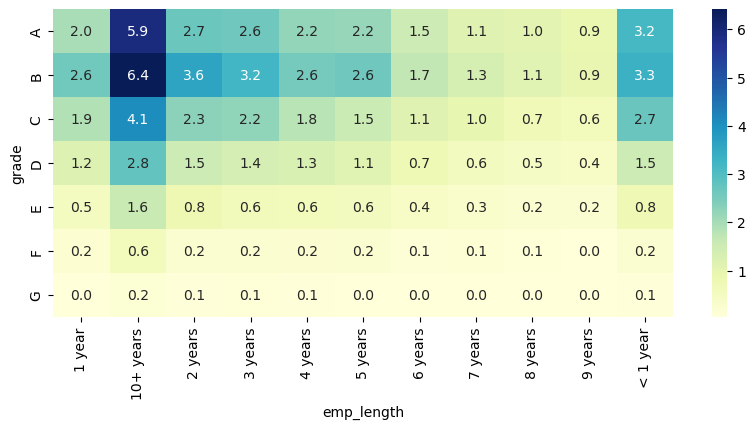

********************************************************************************

 % of Loans applications distributed in grade and home_ownership 



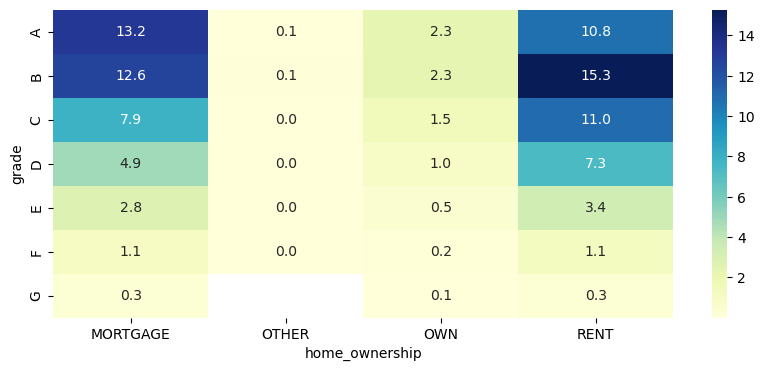


======= Impact of GRADE and HOME_OWNERSHIP together on LOAN STATUS ========



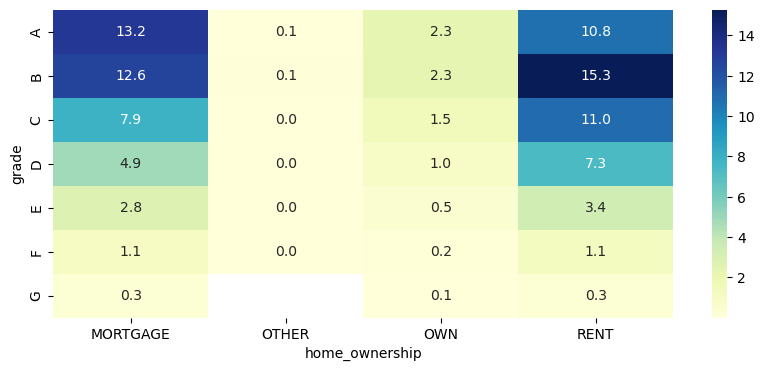

********************************************************************************

 % of Loans applications distributed in grade and verification_status 



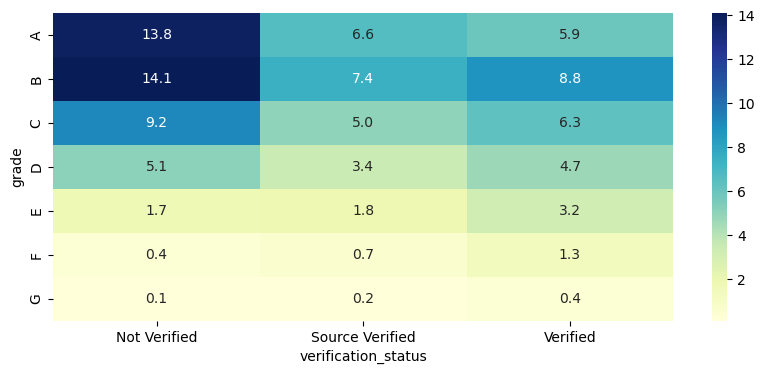


======= Impact of GRADE and VERIFICATION_STATUS together on LOAN STATUS ========



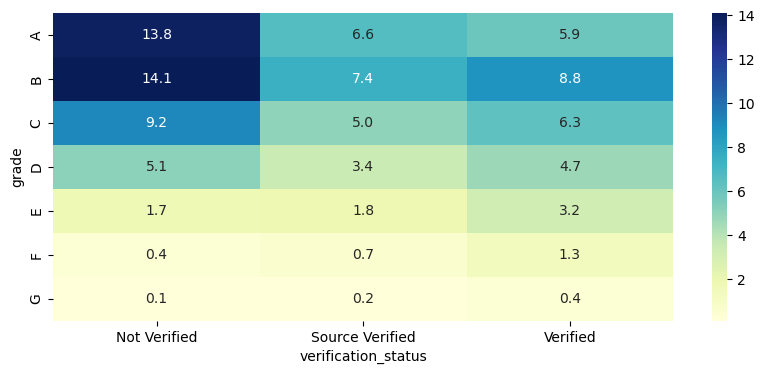

********************************************************************************

 % of Loans applications distributed in grade and purpose 



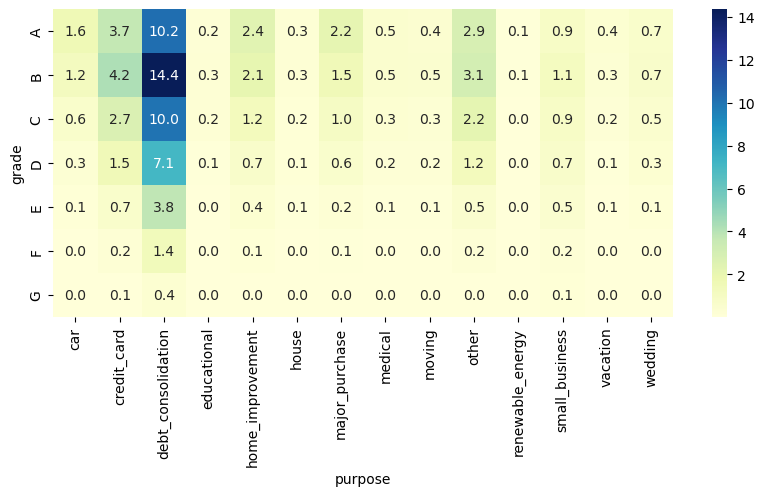


======= Impact of GRADE and PURPOSE together on LOAN STATUS ========



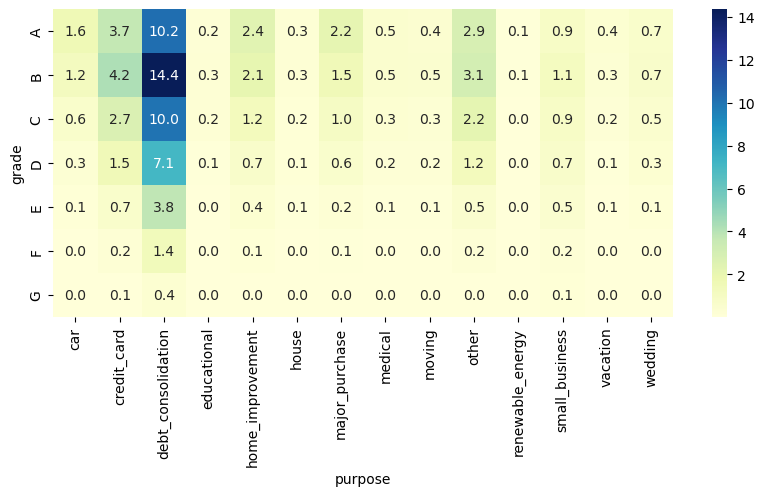

********************************************************************************

 % of Loans applications distributed in emp_length and home_ownership 



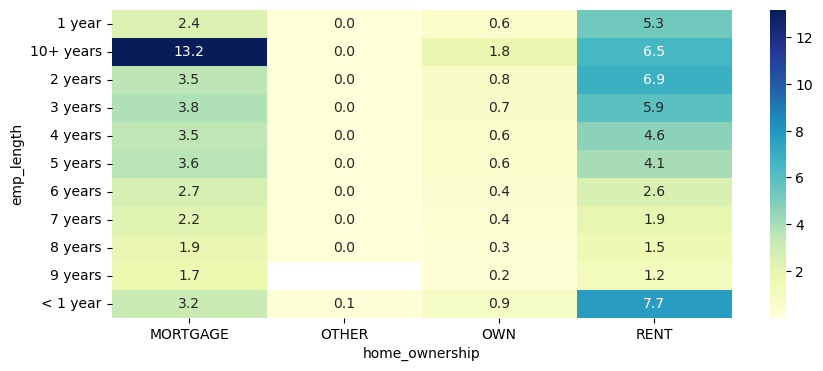


======= Impact of EMP_LENGTH and HOME_OWNERSHIP together on LOAN STATUS ========



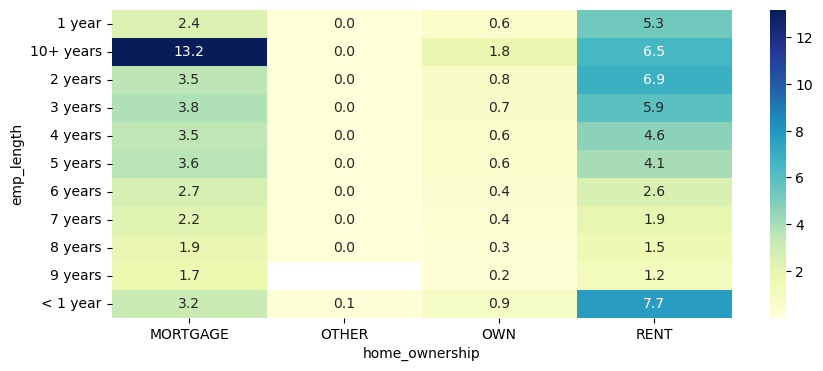

********************************************************************************

 % of Loans applications distributed in emp_length and verification_status 



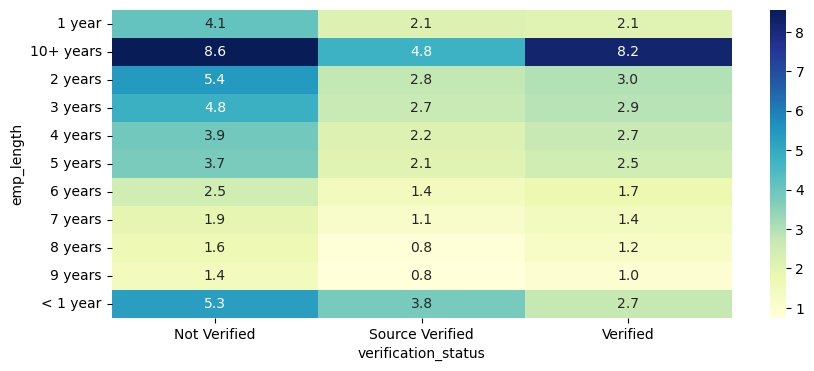


======= Impact of EMP_LENGTH and VERIFICATION_STATUS together on LOAN STATUS ========



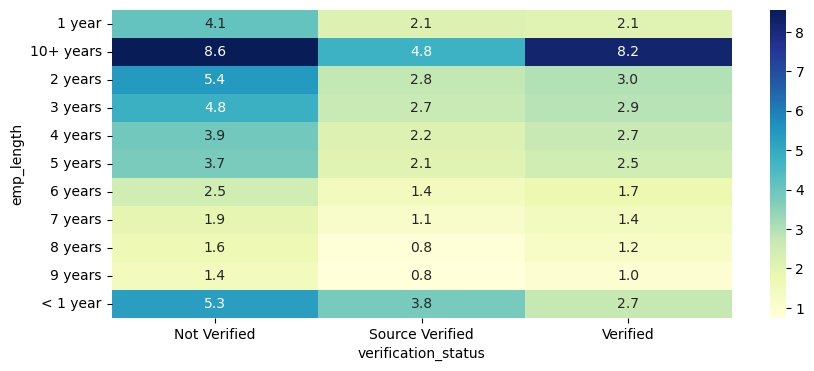

********************************************************************************

 % of Loans applications distributed in emp_length and purpose 



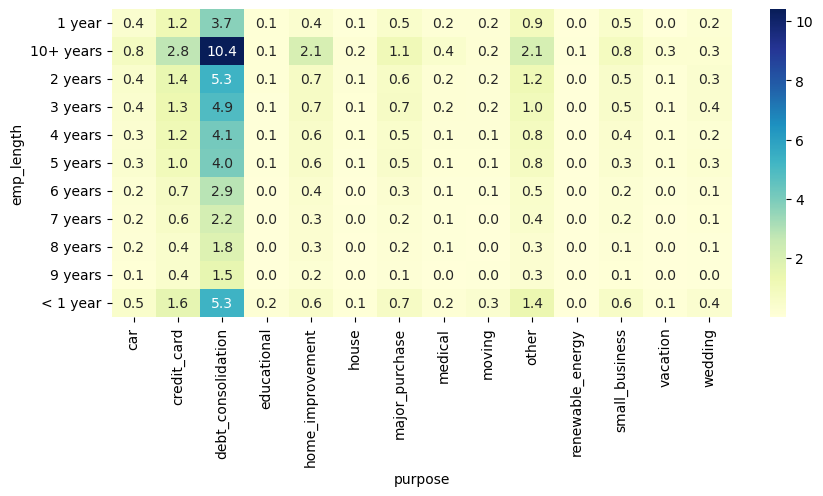


======= Impact of EMP_LENGTH and PURPOSE together on LOAN STATUS ========



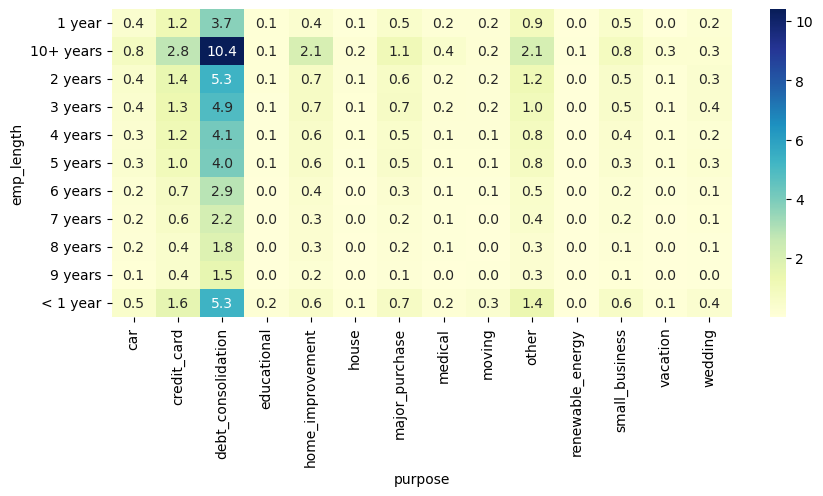

********************************************************************************

 % of Loans applications distributed in home_ownership and verification_status 



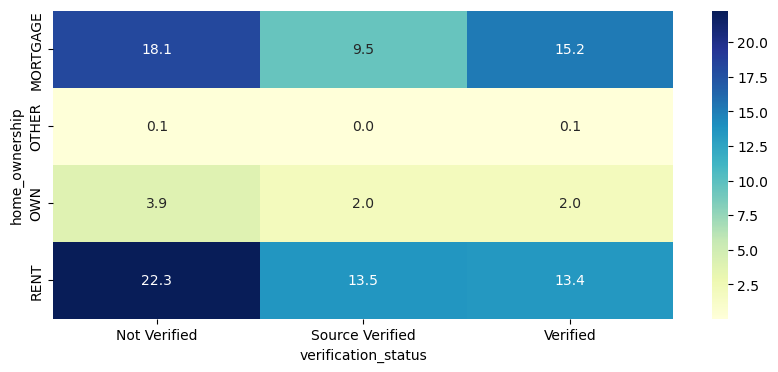


======= Impact of HOME_OWNERSHIP and VERIFICATION_STATUS together on LOAN STATUS ========



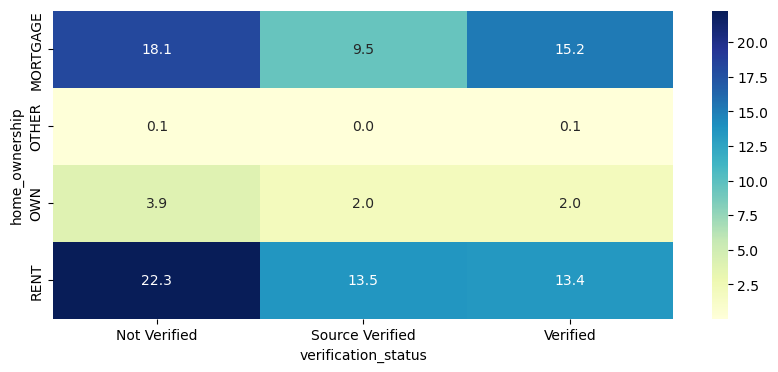

********************************************************************************

 % of Loans applications distributed in home_ownership and purpose 



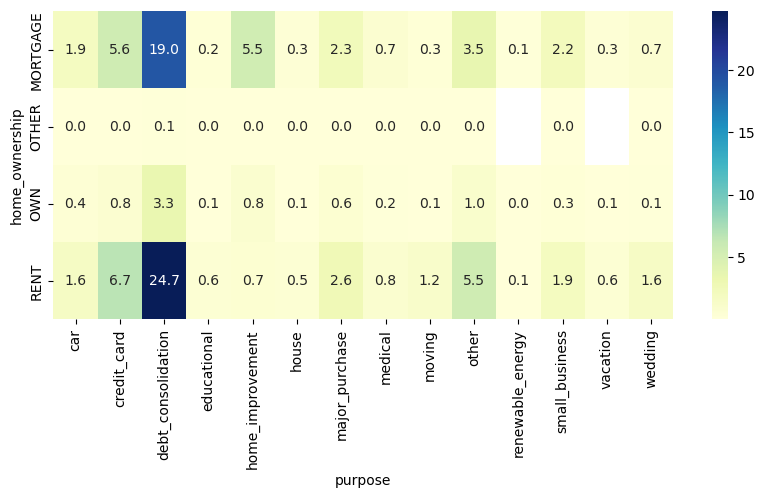


======= Impact of HOME_OWNERSHIP and PURPOSE together on LOAN STATUS ========



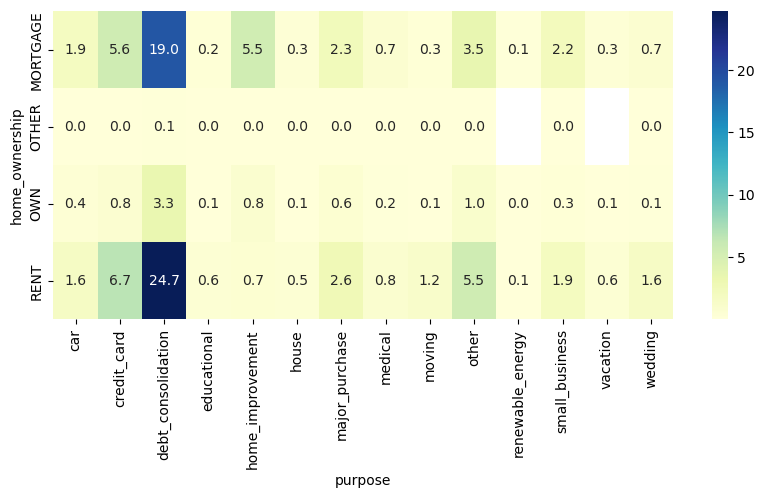

********************************************************************************

 % of Loans applications distributed in verification_status and purpose 



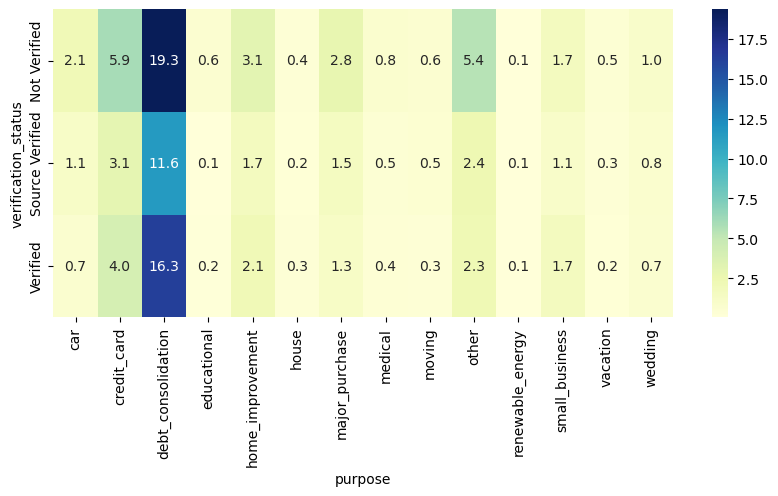


======= Impact of VERIFICATION_STATUS and PURPOSE together on LOAN STATUS ========



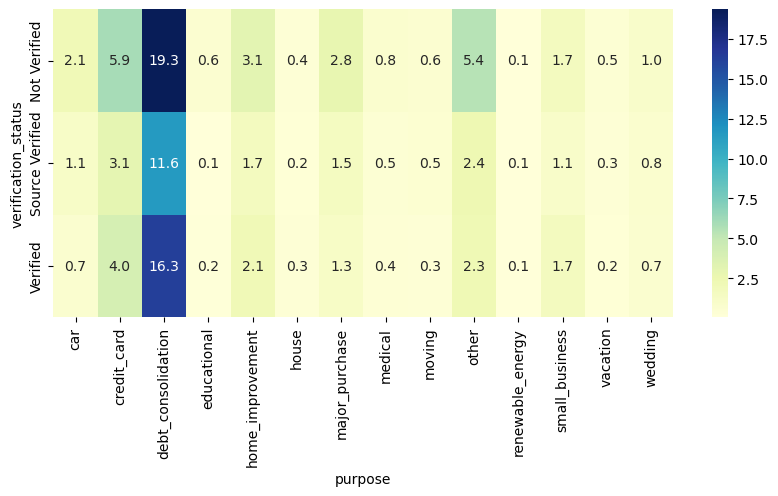

********************************************************************************


In [284]:
fields = ['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose']

for i in range(len(fields)):
    for j in range(i + 1, len(fields)):
        row = fields[i]
        column = fields[j]

        t = pd.pivot_table(
            loandata, 
            index=row, 
            columns=column, 
            values='loan_amnt', 
            aggfunc='count',
            ).apply(lambda x: x * 100/len(loandata))

        if len(t) == 0:
            continue

            
        print(f"\n % of Loans applications distributed in {row} and {column} \n")

        plt.figure(figsize=(10, 4))
        sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.1f')
        plt.show()
      

        if len(t) == 0:
            continue

        print(f"\n======= Impact of {row.upper()} and {column.upper()} together on LOAN STATUS ========\n")

        #sns.set(rc={'figure.figsize': (10, 4)})
        plt.figure(figsize=(10, 4))
        sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.1f')
        plt.show()

        
        
        print("*" * 80)
   

<span style="color:green">Inferences - Bivariate Analysis on Categorical Variables:  </span>

- term & Grade - G grade loans with 36 month tenure has highest chance of default (37%) where as A grade loans with 36 month tenure has lowest chance of default(5.9%).  

- term & Pupose - Education loan and small business purpose loan with 60 month tenure is very likey to get default (43.8% and 35% resp).  

- Grade and emp_length - G grade loans with 1 year of employment length has very high chance of getting defalt i.e. 70.6%. F grade loans with 9 years of employment length has second highest chance of getting defalt i.e. 47.6%.  

